# Step 1. Import data from the webscraping

In [46]:
import pandas as pd
import glob
import os

# Get the parent directory path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Find all files in the parent directory matching the webscrape pattern
csv_pattern = os.path.join(parent_dir, "webscrape_*.csv")
csv_files = glob.glob(csv_pattern)

# Store column headers for each file
all_headers = {}
consistent = True
first_file = None

print(f"Found {len(csv_files)} webscrape CSV files")

# Loop through each file and get headers
for file in csv_files:
    filename = os.path.basename(file)
    
    # Just read the headers without loading entire file
    headers = pd.read_csv(file, nrows=0).columns.tolist()
    all_headers[filename] = headers
    
    # Store first file's headers as reference
    if first_file is None:
        first_file = filename
        reference_headers = headers
        print(f"Reference headers from {first_file}: {reference_headers}")
    # Compare current file with reference
    elif headers != reference_headers:
        consistent = False
        print(f"\nMISMATCH in {filename}:")
        
        # Find and show differences
        missing = set(reference_headers) - set(headers)
        extra = set(headers) - set(reference_headers)
        
        if missing:
            print(f"  Missing columns: {missing}")
        if extra:
            print(f"  Extra columns: {extra}")

# Print final result
if consistent:
    print("\nAll files have identical column headers")
else:
    print("\nWarning: Column headers differ between files")

Found 73 webscrape CSV files
Reference headers from webscrape_2023-08-15_09-20-02.csv: ['title', 'company', 'location', 'salary', 'description']

All files have identical column headers


# Step 2. Add date and date-times so we can identify where each job came from

In [47]:
# Create DataFrames with dates extracted from filenames
import pandas as pd
import re
from datetime import datetime

# Dictionary to store all DataFrames
dataframes = {}

# Regular expression to extract date and time from filename
date_pattern = r'webscrape_(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})\.csv'

# Process each CSV file
for file in csv_files:
    filename = os.path.basename(file)
    
    # Extract date using regex
    match = re.search(date_pattern, filename)
    if match:
        date_str = match.group(1)  # YYYY-MM-DD
        time_str = match.group(2).replace('-', ':')  # Convert to HH:MM:SS
        datetime_str = f"{date_str} {time_str}"
        
        # Parse to datetime object
        file_datetime = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
        
        # Read the CSV
        df = pd.read_csv(file)
        
        # Add date columns
        df['scrape_date'] = file_datetime.date()
        df['scrape_datetime'] = file_datetime
        
        # Store in dictionary
        dataframes[filename] = df
        
        print(f"Loaded {filename} with {len(df)} rows, scraped on {file_datetime}")
    else:
        print(f"Warning: Couldn't extract date from {filename}")

print(f"\nProcessed {len(dataframes)} files")

# Example to verify date columns were added correctly
if dataframes:
    first_key = list(dataframes.keys())[0]
    print(f"\nExample from {first_key}:")
    print(dataframes[first_key][['scrape_date', 'scrape_datetime']].head(2))

Loaded webscrape_2023-08-15_09-20-02.csv with 3923 rows, scraped on 2023-08-15 09:20:02
Loaded webscrape_2023-08-23_09-55-48.csv with 4151 rows, scraped on 2023-08-23 09:55:48
Loaded webscrape_2023-08-30_10-13-36.csv with 3897 rows, scraped on 2023-08-30 10:13:36
Loaded webscrape_2023-09-07_09-32-27.csv with 4266 rows, scraped on 2023-09-07 09:32:27
Loaded webscrape_2023-09-27_11-14-05.csv with 3458 rows, scraped on 2023-09-27 11:14:05
Loaded webscrape_2023-10-04_09-34-49.csv with 3712 rows, scraped on 2023-10-04 09:34:49
Loaded webscrape_2023-10-11_07-59-43.csv with 3362 rows, scraped on 2023-10-11 07:59:43
Loaded webscrape_2023-10-18_09-22-00.csv with 3899 rows, scraped on 2023-10-18 09:22:00
Loaded webscrape_2023-11-01_08-31-18.csv with 4629 rows, scraped on 2023-11-01 08:31:18
Loaded webscrape_2023-11-08_10-36-53.csv with 1859 rows, scraped on 2023-11-08 10:36:53
Loaded webscrape_2023-11-22_10-11-56.csv with 2762 rows, scraped on 2023-11-22 10:11:56
Loaded webscrape_2023-11-29_10-0

# Step 3. Merge the webscrape CSVs

In [48]:
# Merge all DataFrames into one combined dataset
import pandas as pd

# Check if we have DataFrames to merge
if not dataframes:
    print("No DataFrames to merge!")
else:
    # Combine all DataFrames from the dictionary
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    
    # Basic info about the combined dataset
    print(f"Combined dataset created successfully!")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Show unique scrape dates to verify we have data from different days
    unique_dates = combined_df['scrape_date'].unique()
    print(f"\nData includes {len(unique_dates)} unique dates:")
    for date in sorted(unique_dates):
        count = len(combined_df[combined_df['scrape_date'] == date])
        print(f"  {date}: {count:,} rows")
    
    # Preview of the combined data
    print("\nPreview of combined dataset:")
    # Show date columns first, then a few others
    preview_cols = ['scrape_date', 'scrape_datetime'] 
    # Add a few more columns for preview (adjust as needed)
    other_cols = [col for col in combined_df.columns 
                 if col not in ['scrape_date', 'scrape_datetime']][:3]
    preview_cols.extend(other_cols)
    
    print(combined_df[preview_cols].head())

Combined dataset created successfully!
Total rows: 253,897
Total columns: 7

Data includes 72 unique dates:
  2023-08-15: 3,923 rows
  2023-08-23: 4,151 rows
  2023-08-30: 3,897 rows
  2023-09-07: 4,266 rows
  2023-09-27: 3,458 rows
  2023-10-04: 3,712 rows
  2023-10-11: 3,362 rows
  2023-10-18: 3,899 rows
  2023-11-01: 4,629 rows
  2023-11-08: 1,859 rows
  2023-11-22: 2,762 rows
  2023-11-29: 2,931 rows
  2023-12-06: 3,958 rows
  2023-12-13: 4,141 rows
  2023-12-20: 3,775 rows
  2024-01-03: 3,193 rows
  2024-01-10: 4,081 rows
  2024-01-17: 3,630 rows
  2024-01-31: 3,239 rows
  2024-02-07: 3,268 rows
  2024-02-14: 3,427 rows
  2024-02-21: 3,644 rows
  2024-03-13: 3,050 rows
  2024-03-20: 3,491 rows
  2024-03-27: 2,945 rows
  2024-04-10: 3,504 rows
  2024-04-17: 4,330 rows
  2024-04-24: 3,500 rows
  2024-05-01: 2,978 rows
  2024-05-08: 3,199 rows
  2024-05-15: 2,871 rows
  2024-05-22: 2,951 rows
  2024-05-29: 2,248 rows
  2024-06-05: 2,983 rows
  2024-06-12: 2,814 rows
  2024-06-19: 2,5

# Step 4. Tidying data.

## 4.1. Removing rows that aren't jobs.

### 4.1.1. Where 'illustration of bank notes' in job title

In [49]:
# Remove rows where title contains "Illustration of banknotes" with flexible matching

# First check if title column exists
if "title" not in combined_df.columns:
    print("Warning: 'title' column not found in the dataset.")
else:
    # Display some titles to understand what we're working with
    print("Sample of titles in the dataset:")
    sample_titles = combined_df["title"].dropna().sample(min(5, len(combined_df))).tolist()
    for title in sample_titles:
        print(f"  - {title}")
    
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches more flexibly
    potential_matches = combined_df[combined_df["title"].str.contains("Illustration of banknote", case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with 'Illustration of banknote'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching titles:")
        for title in potential_matches["title"].unique()[:5]:
            print(f"  - {title}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["title"].str.contains("Illustration of banknote", case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()

Sample of titles in the dataset:
  -                     Social Prescriber
  -                     Qualified Dental Nurse - Excellent benefits
  -                     Community Staff Nurse
  -                     Night Nurse RGN
  -                     Assistant Clinical Lead

Found 4659 potential matches with 'Illustration of banknote'

Sample of matching titles:
  -                 Illustration of banknotes
  - 
                Illustration of banknotes

Original dataset: 253,897 rows
Removed: 4,659 rows
Filtered dataset: 249,238 rows


### 4.1.2. Where company includes 'boost your CV'

In [50]:
# Remove rows where company contains "Boost your CV"

# First check if company column exists
if "company" not in combined_df.columns:
    print("Warning: 'company' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches more flexibly
    potential_matches = combined_df[combined_df["company"].str.contains("Boost your CV", case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with 'Boost your CV'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching company entries:")
        for company in potential_matches["company"].unique()[:3]:
            print(f"  - {company}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["company"].str.contains("Boost your CV", case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()


Found 3500 potential matches with 'Boost your CV'

Sample of matching company entries:
  -         Boost your CV
        It takes 2 minutes and it's free.Try ValueMyCV now ❯

Original dataset: 249,238 rows
Removed: 3,500 rows
Filtered dataset: 245,738 rows


### 4.1.3. Where company contains 'recent the newest jobs for this search'

In [51]:
# Remove rows where company contains "Receive the newest jobs"

# First check if company column exists
if "company" not in combined_df.columns:
    print("Warning: 'company' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches with flexible matching
    search_phrase = "Receive the newest jobs"
    potential_matches = combined_df[combined_df["company"].str.contains(search_phrase, case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with '{search_phrase}'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching company entries:")
        for company in potential_matches["company"].unique()[:3]:
            print(f"  - {company}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["company"].str.contains(search_phrase, case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()


Found 5608 potential matches with 'Receive the newest jobs'

Sample of matching company entries:
  -             Receive the newest jobs for this search by email:

Original dataset: 245,738 rows
Removed: 5,608 rows
Filtered dataset: 240,130 rows


### Step 4.1.4. Remove missing salaries

##### *Preliminary check*

We first check to see if any of these rows actually contain the salary in the job description. Our analysis below shows that:
1. All of the rows that have a £ sign in the job title already have a salary in the salary, so
2. Missing salaries are not found in the job title, and
3. Where a salary is cited in the job title *and* the salary field, these are usually consistent. They differ usually by unit (i.e. £11p/h becomes £11 in the salary field)

In [52]:
# Updated salary extraction with improved regex patterns

# First check if combined_df exists
if "title" not in combined_df.columns or "salary" not in combined_df.columns:
    print("Warning: Missing required columns")
else:
    # Create DF with rows that have '£' in title AND non-null salary field
    pound_in_title = combined_df["title"].str.contains("£", na=False)
    has_salary_value = ~combined_df["salary"].isna()
    comparison_df = combined_df[pound_in_title & has_salary_value].copy()
    
    print(f"Found {len(comparison_df):,} rows with '£' in title AND salary field populated")
    
    # Improved function to extract salary from title
    def extract_salary_from_title(title):
        # Updated patterns with optional space after £
        patterns = [
            r'£\s*(\d{1,3}[,.]?\d{0,3}[kK]?)', # Basic amounts like £50k, £ 50,000
            r'£\s*(\d{1,3}[,.]?\d{0,3})-£?\s*(\d{1,3}[,.]?\d{0,3}[kK]?)', # Ranges like £30-£40k or £ 30-£ 40k
            r'£\s*(\d{1,3}[,.]?\d{0,3}[kK]?)[/\s]*(day|hour|month|year|pa|p\.a\.)', # With time period
            r'£\s*(\d{1,3}[,.]?\d{0,3})[kK]\s*-\s*£?\s*(\d{1,3}[,.]?\d{0,3})[kK]', # Format like £24K-£32K
        ]
        
        for pattern in patterns:
            match = re.search(pattern, title)
            if match:
                return match.group(0)
        return None
    
    # Add extracted salary column
    comparison_df['title_salary'] = comparison_df['title'].apply(extract_salary_from_title)
    
    # Count how many titles we could extract salaries from
    extracted_count = comparison_df['title_salary'].notna().sum()
    print(f"Successfully extracted salary from {extracted_count} titles ({extracted_count/len(comparison_df)*100:.1f}%)")
    
    # Check the previously failed cases
    try:
        failed_before = failed_extraction_df.copy()
        failed_before['updated_title_salary'] = failed_before['title'].apply(extract_salary_from_title)
        
        newly_extracted = failed_before['updated_title_salary'].notna().sum()
        print(f"\nOf the {len(failed_before)} previously failed extractions:")
        print(f"  - Now successfully extracted: {newly_extracted} ({newly_extracted/len(failed_before)*100:.1f}%)")
        
        if newly_extracted > 0:
            print("\nNewly extracted examples:")
            for _, row in failed_before[failed_before['updated_title_salary'].notna()].iterrows():
                print(f"Title: {row['title']}")
                print(f"  - Extracted salary: {row['updated_title_salary']}")
                print(f"  - Salary field: {row['salary']}")
                print()
    except NameError:
        print("\nPreviously failed cases dataset not available.")
    
    # Get current failed extractions
    failed_now = comparison_df[comparison_df['title_salary'].isna() & comparison_df['title'].str.contains('£', na=False)]
    print(f"\nStill failed to extract from {len(failed_now)} titles")
    
    if len(failed_now) > 0 and len(failed_now) <= 20:
        print("\nRemaining failure cases:")
        for _, row in failed_now.iterrows():
            print(f"Title: {row['title']}")
            print(f"Salary field: {row['salary']}")
            print()

Found 4,575 rows with '£' in title AND salary field populated
Successfully extracted salary from 4564 titles (99.8%)

Previously failed cases dataset not available.

Still failed to extract from 11 titles

Remaining failure cases:
Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £65,000

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £60,000

Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £60,000

Title:                     Post Market Surveillance Manager - Oxfor

In [53]:
# Compare extracted salary from title with salary field

# First ensure we have the updated extracted salary data
if 'comparison_df' not in locals() or 'title_salary' not in comparison_df.columns:
    print("Error: Please run the updated salary extraction code first")
else:
    # Focus only on rows where we successfully extracted a salary
    valid_comparisons = comparison_df[comparison_df['title_salary'].notna()].copy()
    
    print(f"Analyzing {len(valid_comparisons)} rows with successfully extracted title salaries")
    
    # Function to normalize salary for comparison
    def normalize_salary(salary_text):
        # Convert to string if not already
        salary_str = str(salary_text).lower()
        # Remove spaces and common separators
        salary_str = salary_str.replace(' ', '').replace(',', '')
        return salary_str
    
    # Add normalized versions of both salary fields
    valid_comparisons['norm_title_salary'] = valid_comparisons['title_salary'].apply(normalize_salary)
    valid_comparisons['norm_field_salary'] = valid_comparisons['salary'].apply(normalize_salary)
    
    # Check for matches (using contains rather than exact match)
    valid_comparisons['exact_match'] = valid_comparisons['norm_title_salary'] == valid_comparisons['norm_field_salary']
    valid_comparisons['partial_match'] = valid_comparisons.apply(
        lambda row: (row['norm_title_salary'] in row['norm_field_salary'] or 
                     row['norm_field_salary'] in row['norm_title_salary']), 
        axis=1
    )
    
    # Count match types
    exact_matches = valid_comparisons['exact_match'].sum()
    partial_matches = valid_comparisons['partial_match'].sum() - exact_matches  # Remove overlap with exact
    no_matches = len(valid_comparisons) - exact_matches - partial_matches
    
    # Calculate percentages
    total = len(valid_comparisons)
    exact_pct = (exact_matches / total) * 100
    partial_pct = (partial_matches / total) * 100
    no_match_pct = (no_matches / total) * 100
    
    # Print match statistics
    print("\nSalary match analysis:")
    print(f"  - Exact matches: {exact_matches:,} ({exact_pct:.1f}%)")
    print(f"  - Partial matches: {partial_matches:,} ({partial_pct:.1f}%)")
    print(f"  - No match: {no_matches:,} ({no_match_pct:.1f}%)")
    
    # Show examples of each type
    print("\nEXAMPLES OF EXACT MATCHES:")
    for _, row in valid_comparisons[valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()
    
    print("\nEXAMPLES OF PARTIAL MATCHES:")
    for _, row in valid_comparisons[valid_comparisons['partial_match'] & ~valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()
    
    print("\nEXAMPLES OF NO MATCHES:")
    for _, row in valid_comparisons[~valid_comparisons['partial_match'] & ~valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()

Analyzing 4564 rows with successfully extracted title salaries

Salary match analysis:
  - Exact matches: 1,424 (31.2%)
  - Partial matches: 3,140 (68.8%)
  - No match: 0 (0.0%)

EXAMPLES OF EXACT MATCHES:
Title:                     Associate Dentist - £14-15 per UDA
  - Title salary: £14
  - Field salary: £14

Title:                     Associate Dentist - Up to £14 per UDA
  - Title salary: £14
  - Field salary: £14

Title:                     Dental Nurse - £12 per hour
  - Title salary: £12
  - Field salary: £12


EXAMPLES OF PARTIAL MATCHES:
Title:                     Newly Qualified Registered Nurse (RGN/RMN/RNLD) – Preston – Nursing Home Setting – £19.00 per hour – Full Training and Support Provided.
  - Title salary: £19.00
  - Field salary: £19

Title:                     Vet Surgeon Vacancy - small animal & exotics - Wirral (to £70K)
  - Title salary: £70K
  - Field salary: £70

Title:                     Newly Qualified Registered Nurse (RGN/RMN/RNLD) – Burnley – Nursing Hom

##### *Removal*

In [54]:
# Remove rows where 'salary' is missing (now that we've verified salary data quality)

# First check if salary column exists
if "salary" not in combined_df.columns:
    print("Warning: 'salary' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Check how many rows have missing salary values
    missing_salary_count = combined_df["salary"].isna().sum()
    missing_percent = (missing_salary_count / original_count) * 100
    
    print(f"Found {missing_salary_count:,} rows ({missing_percent:.1f}%) with missing salary values")
    
    # Drop rows where salary is missing
    filtered_df = combined_df.dropna(subset=["salary"])
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {missing_salary_count:,} rows ({missing_percent:.1f}%)")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()
    
    print("\nSalary column statistics after cleaning:")
    # Check null values (should be zero now)
    null_count = combined_df["salary"].isna().sum()
    print(f"  - Null values: {null_count}")
    
    # Check unique value count
    unique_count = combined_df["salary"].nunique()
    print(f"  - Unique values: {unique_count:,}")
    
    # Sample values
    print("\nSample salary values:")
    for value in combined_df["salary"].sample(5).tolist():
        print(f"  - {value}")

Found 11,301 rows (4.7%) with missing salary values

Original dataset: 240,130 rows
Removed: 11,301 rows (4.7%)
Filtered dataset: 228,829 rows

Salary column statistics after cleaning:
  - Null values: 0
  - Unique values: 32,539

Sample salary values:
  - £30,000
  - £46,148
  - £26,118
  - £65,000
  - £20


In [55]:
# Analyze 'TOP MATCH' salary rows and check for '£' in description

# First check if necessary columns exist
if "salary" not in combined_df.columns:
    print("Warning: 'salary' column not found in the dataset.")
elif "description" not in combined_df.columns:
    print("Warning: 'description' column not found in the dataset.")
else:
    # Find all rows where salary is 'TOP MATCH'
    top_match_mask = combined_df["salary"] == "TOP MATCH"
    top_match_df = combined_df[top_match_mask]
    
    top_match_count = len(top_match_df)
    top_match_percent = (top_match_count / len(combined_df)) * 100
    
    print(f"Found {top_match_count:,} rows ({top_match_percent:.1f}%) with 'TOP MATCH' as salary")
    
    # Check how many have '£' in description
    # Handle NaN values properly
    has_pound_in_desc = top_match_df["description"].astype(str).str.contains("£", na=False)
    pound_count = has_pound_in_desc.sum()
    pound_percent = (pound_count / top_match_count) * 100 if top_match_count > 0 else 0
    
    print(f"\nOf these 'TOP MATCH' rows:")
    print(f"  - {pound_count:,} rows ({pound_percent:.1f}%) have '£' in description")
    print(f"  - {top_match_count - pound_count:,} rows ({100 - pound_percent:.1f}%) don't have '£' in description")
    
    # Show examples of descriptions with pound signs
    if pound_count > 0:
        print("\nExample descriptions with '£' (first 100 characters):")
        for desc in top_match_df[has_pound_in_desc]["description"].sample(min(3, pound_count)).tolist():
            # Make sure desc is a string before operating on it
            if pd.isna(desc):
                print("  - [Missing description]")
                print()
                continue
                
            # Convert to string if needed
            if not isinstance(desc, str):
                desc = str(desc)
                
            # Find the first occurrence of £ and show context
            pound_pos = desc.find('£')
            start_pos = max(0, pound_pos - 50)
            end_pos = min(len(desc), pound_pos + 50)
            context = desc[start_pos:end_pos]
            print(f"  - ...{context}...")
            print()
    
    # Show examples without pound signs
    if top_match_count - pound_count > 0:
        print("\nExample descriptions without '£' (first 100 characters):")
        for desc in top_match_df[~has_pound_in_desc]["description"].sample(min(3, top_match_count - pound_count)).tolist():
            # Safely handle NaN values
            if pd.isna(desc):
                print("  - [Missing description]")
                print()
                continue
                
            # Convert to string if needed
            if not isinstance(desc, str):
                desc = str(desc)
                
            print(f"  - {desc[:100]}...")
            print()

Found 350 rows (0.2%) with 'TOP MATCH' as salary

Of these 'TOP MATCH' rows:
  - 102 rows (29.1%) have '£' in description
  - 248 rows (70.9%) don't have '£' in description

Example descriptions with '£' (first 100 characters):
  - ...Nursing Community and Dementia Nursing Community. £21.50ph Hilltop Court Care Home, Stockport, SK4 1...

  - ...hly Specialist Dietitian (Band 6/7) Salary: Up to £19,900 (£49,750 WTE) Contract: Permanent Hours: P...

  - ...Site Queens Medical Center Town Nottingham Salary £22,816 - £24,336 pro rata Salary period Yearly......


Example descriptions without '£' (first 100 characters):
  -             Are you a skilled healthcare professional eager for a fulfilling career change? Look no ...

  -             HFH Healthcare is an independent healthcare organisation who deliver exceptional quality...

  -             Health Care Assistant Vacancy: Frodsham (Please note: Due to us being a healthcare recru...



Where are we? We found that some of the 'salary' contains 'top match'. I also reflected that in my R script, I've got rid of these. IN some cases, albeit these are still small numbers, there is a salary that can be found and extracted from the job description. So this needs to be sorted.

WE also need to do PT/FT/hours, and create annualised equivalients. 
Town/city/county/region etc.
Some standardised employer names (Bupa, NHS, Nuffield etc to makej sure we capture these)

# Step 5. Hours & Salary

In [56]:
# One-chunk data exploration code
import pandas as pd
import numpy as np

# Set display options for better output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# Basic info
print("=== BASIC INFO ===")
print(f"Shape: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
print(f"Memory usage: {combined_df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
print("\nColumn names:")
for col in combined_df.columns:
    print(f"- {col}")

# Data types
print("\n=== DATA TYPES ===")
print(combined_df.dtypes.value_counts())
print("\nDetailed data types:")
for col, dtype in combined_df.dtypes.items():
    print(f"- {col}: {dtype}")

# Sample data
print("\n=== SAMPLE DATA (5 rows) ===")
print(combined_df.head())

# Missing values
print("\n=== MISSING VALUES ===")
missing = combined_df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]  # Only show columns with missing values
if len(missing) > 0:
    missing_pct = (missing / len(combined_df) * 100).round(2)
    missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
    print(missing_df)
    print(f"\nTotal missing: {missing.sum()} values ({missing.sum() / (combined_df.shape[0] * combined_df.shape[1]) * 100:.2f}% of all cells)")
else:
    print("No missing values found!")

# Column stats
print("\n=== COLUMN DETAILS ===")
stats = []
for col in combined_df.columns:
    unique_count = combined_df[col].nunique()
    missing_count = combined_df[col].isna().sum()
    missing_pct = missing_count / len(combined_df) * 100
    
    stats.append({
        'Column': col,
        'Type': combined_df[col].dtype,
        'Unique Values': unique_count,
        'Missing Values': missing_count,
        'Missing %': f"{missing_pct:.2f}%"
    })
stats_df = pd.DataFrame(stats)
print(stats_df)

# Numeric columns
numeric_cols = combined_df.select_dtypes(include=['number']).columns
if len(numeric_cols) > 0:
    print("\n=== NUMERIC COLUMNS STATS ===")
    print(combined_df[numeric_cols].describe())
    
    # Skewness
    print("\nSkewness:")
    skew = combined_df[numeric_cols].skew().sort_values(ascending=False)
    skew_df = pd.DataFrame({'Skewness': skew})
    print(skew_df)

# Categorical columns
cat_cols = combined_df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    print("\n=== CATEGORICAL COLUMNS ===")
    for col in cat_cols:
        print(f"\nTop values for '{col}':")
        val_counts = combined_df[col].value_counts().head(10)
        val_pcts = (val_counts / len(combined_df) * 100).round(2)
        val_df = pd.DataFrame({'Count': val_counts, 'Percentage': val_pcts})
        print(val_df)

# Correlation
if len(numeric_cols) >= 2:
    print("\n=== CORRELATION MATRIX ===")
    corr = combined_df[numeric_cols].corr().round(2)
    print(corr)
    
    # High correlations
    print("\nHigh correlations (|r| >= 0.7):")
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) >= 0.7:
                high_corr.append({
                    'Column 1': corr.columns[i],
                    'Column 2': corr.columns[j],
                    'Correlation': corr.iloc[i, j]
                })
    if high_corr:
        print(pd.DataFrame(high_corr))
    else:
        print("No high correlations found")

# Duplicates
print("\n=== DUPLICATES ===")
dup_count = combined_df.duplicated().sum()
print(f"Duplicate rows: {dup_count} ({dup_count/len(combined_df)*100:.2f}%)")

# Summary
print("\n=== SUMMARY ===")
print(f"• Rows: {combined_df.shape[0]}, Columns: {combined_df.shape[1]}")
print(f"• Data types: {', '.join(combined_df.dtypes.value_counts().index.astype(str))}")
print(f"• Numeric columns: {len(numeric_cols)}")
print(f"• Categorical columns: {len(cat_cols)}")
print(f"• Missing values: {combined_df.isna().sum().sum()} ({combined_df.isna().sum().sum() / (combined_df.shape[0] * combined_df.shape[1]) * 100:.2f}%)")
print(f"• Duplicate rows: {dup_count}")

# High missing columns
high_missing = combined_df.columns[combined_df.isna().mean() > 0.2].tolist()
if high_missing:
    print(f"• Columns with >20% missing values: {', '.join(high_missing)}")

=== BASIC INFO ===
Shape: 228829 rows, 7 columns
Memory usage: 141.44 MB

Column names:
- title
- company
- location
- salary
- description
- scrape_date
- scrape_datetime

=== DATA TYPES ===
object            6
datetime64[us]    1
Name: count, dtype: int64

Detailed data types:
- title: object
- company: object
- location: object
- salary: object
- description: object
- scrape_date: object
- scrape_datetime: datetime64[us]

=== SAMPLE DATA (5 rows) ===
                                                                 title                                               company                                                       location    salary                                                                                          description scrape_date     scrape_datetime
1                                      Advanced Nurse Practitioner ANP                         PP ASSOCIATES LTD                                                      LIVERPOOL, NORTH WEST   £66,181              

## 5.1. Create new salary field

In [57]:
import re
import pandas as pd
import numpy as np

# Completely redesigned function to handle salary extraction
def extract_salary(salary_str):
    # Return NaN if the salary string is missing or not a string
    if pd.isna(salary_str) or not isinstance(salary_str, str):
        return np.nan
    
    # If it's "TOP MATCH" or contains no digits, return NaN
    if salary_str == "TOP MATCH" or not re.search(r'\d', salary_str):
        return np.nan
    
    # Normalize the string - remove all pound signs and extra spaces
    normalized = salary_str.replace('£', '').strip()
    
    # Check for salary ranges like "30000-40000" and take the lower value
    if '-' in normalized:
        parts = normalized.split('-')
        normalized = parts[0].strip()
    
    # Try to find the main number pattern
    # We want to capture a number that might have commas as thousand separators
    match = re.search(r'(\d{1,3}(?:,\d{3})*|\d+)(?:\.\d+)?', normalized)
    
    if not match:
        return np.nan
    
    # Get the matched number and remove commas
    number_str = match.group(1).replace(',', '')
    
    try:
        # Convert to integer to ensure we're working with whole numbers
        salary_value = int(number_str)
        
        # Sanity check - cap extremely high values that are likely errors
        if salary_value > 1000000:  # Likely a parsing error if over 1 million
            # Try to determine if this is actually a smaller number with decimal places
            # For example, if we got 3291682 from "£32,916.82"
            if len(str(salary_value)) >= 6 and len(str(salary_value)) <= 8:
                # This might be a case where the decimal was incorrectly parsed
                # Let's try to extract just the main part (first 5-6 digits)
                return int(str(salary_value)[:5])
            return np.nan
        
        return salary_value
    except ValueError:
        return np.nan

# First calculate the new column values
new_salary_values = combined_df['salary'].apply(extract_salary)

# Get the list of all columns
all_columns = list(combined_df.columns)

# Find the position of the 'salary' column
salary_position = all_columns.index('salary')

# If the column already exists, drop it first
if 'equivalent_annual_salary' in combined_df.columns:
    combined_df = combined_df.drop('equivalent_annual_salary', axis=1)

# Insert the new column right after the 'salary' column
combined_df.insert(salary_position + 1, 'equivalent_annual_salary', new_salary_values)

# Add some specific examples to check if the fix works
test_cases = pd.DataFrame({
    'salary': ['£32,000.05', '£24,728.25', '£45,123', '£32,916.82', '£31,529.41', '£27,449.52']
})
test_cases['extracted'] = test_cases['salary'].apply(extract_salary)
print("\nTest cases with the new approach:")
print(test_cases)

# Display the first few rows of the actual data
print("\nUpdated DataFrame:")
print(combined_df[['salary', 'equivalent_annual_salary']].head(10))


Test cases with the new approach:
       salary  extracted
0  £32,000.05      32000
1  £24,728.25      24728
2     £45,123      45123
3  £32,916.82      32916
4  £31,529.41      31529
5  £27,449.52      27449

Updated DataFrame:
             salary  equivalent_annual_salary
1           £66,181                   66181.0
2               £18                      18.0
3           £20,000                   20000.0
5          £100,000                  100000.0
6           £36,718                   36718.0
7           £28,000                   28000.0
9           £30,000                   30000.0
10          £39,500                   39500.0
11          £26,273                   26273.0
12  £38228 ANNUALLY                     382.0


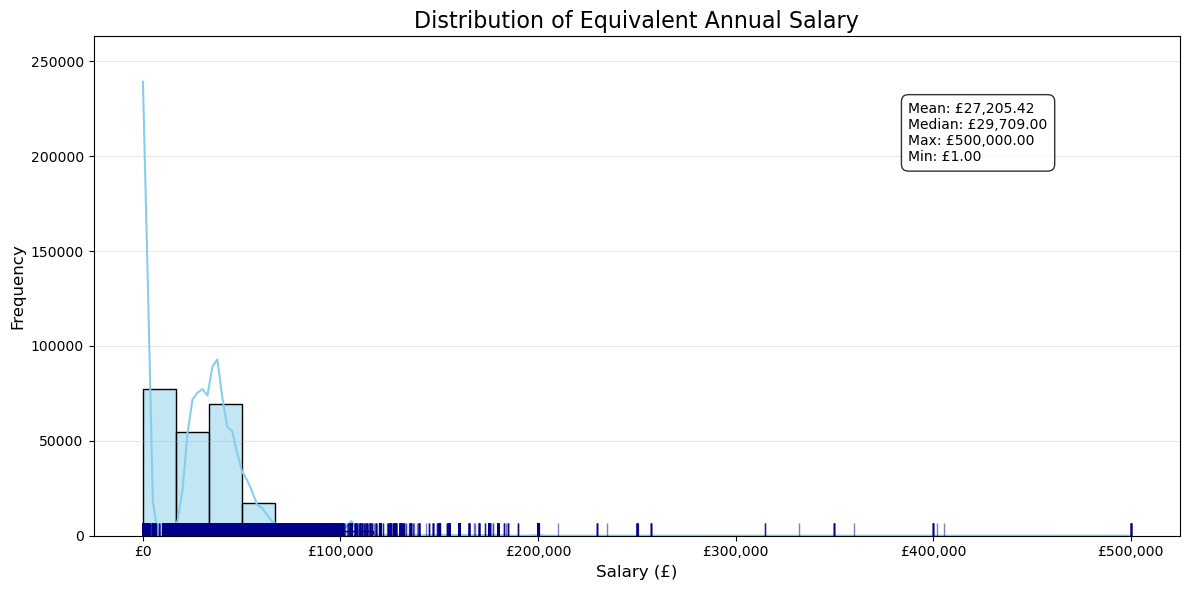

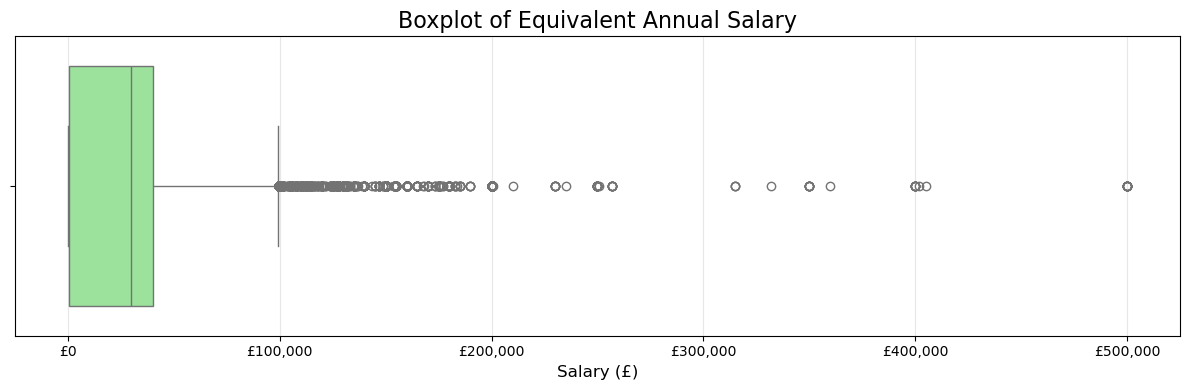

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Remove any remaining NaN values for the visualization
salary_data = combined_df['equivalent_annual_salary'].dropna()

# Create a figure with an appropriate size
plt.figure(figsize=(12, 6))

# Create a histogram with KDE (Kernel Density Estimation) overlay
# This gives you both the histogram bars and a smooth curve
ax = sns.histplot(salary_data, kde=True, color='skyblue', bins=30)

# Add a rug plot at the bottom to show the actual data points
sns.rugplot(salary_data, color='darkblue', alpha=0.5, ax=ax)

# Add some statistics as annotations
mean_salary = salary_data.mean()
median_salary = salary_data.median()
max_salary = salary_data.max()
min_salary = salary_data.min()

stats_text = f"Mean: £{mean_salary:,.2f}\nMedian: £{median_salary:,.2f}\nMax: £{max_salary:,.2f}\nMin: £{min_salary:,.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Set titles and labels
plt.title('Distribution of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Salary (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Format x-axis with commas for thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Add grid lines for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Let's also create a boxplot to better visualize outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=salary_data, orient='h', color='lightgreen')
plt.title('Boxplot of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Salary (£)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2. Apply some logic to make annual equivalent salaries

Current salary statistics:
count    228479.000000
mean      27205.415815
std       24856.404662
min           1.000000
25%         359.000000
50%       29709.000000
75%       40000.000000
max      500000.000000
Name: equivalent_annual_salary, dtype: float64

Updated equivalent annual salaries:
             salary  equivalent_annual_salary
1           £66,181                   66181.0
2               £18                   37440.0
3           £20,000                   20000.0
5          £100,000                  100000.0
6           £36,718                   36718.0
7           £28,000                   28000.0
9           £30,000                   30000.0
10          £39,500                   39500.0
11          £26,273                   26273.0
12  £38228 ANNUALLY                   99320.0


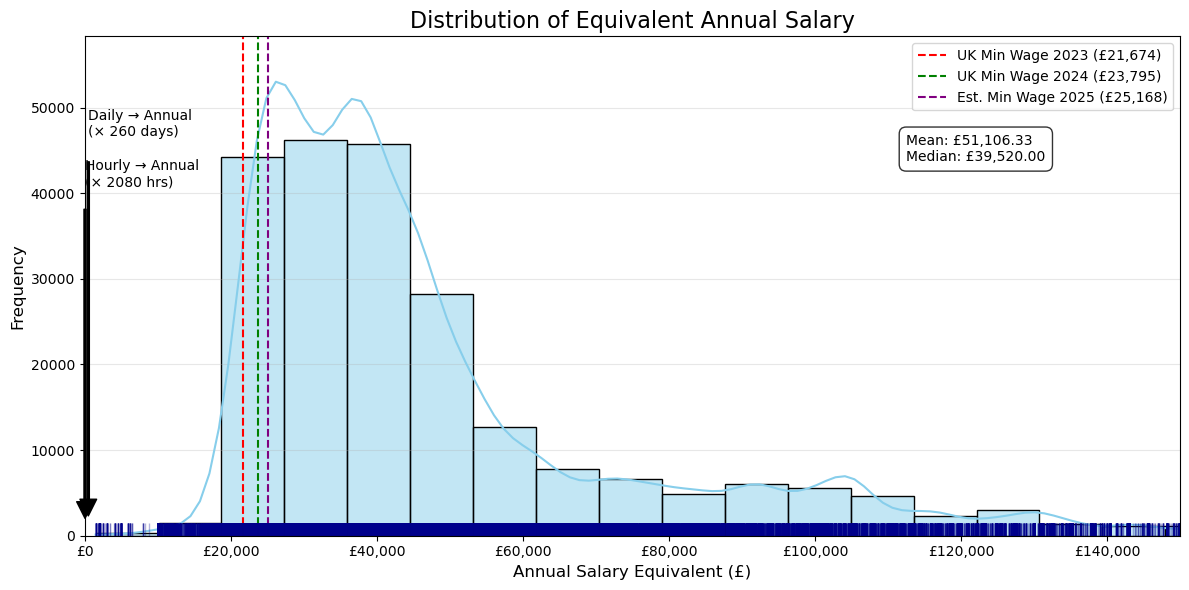

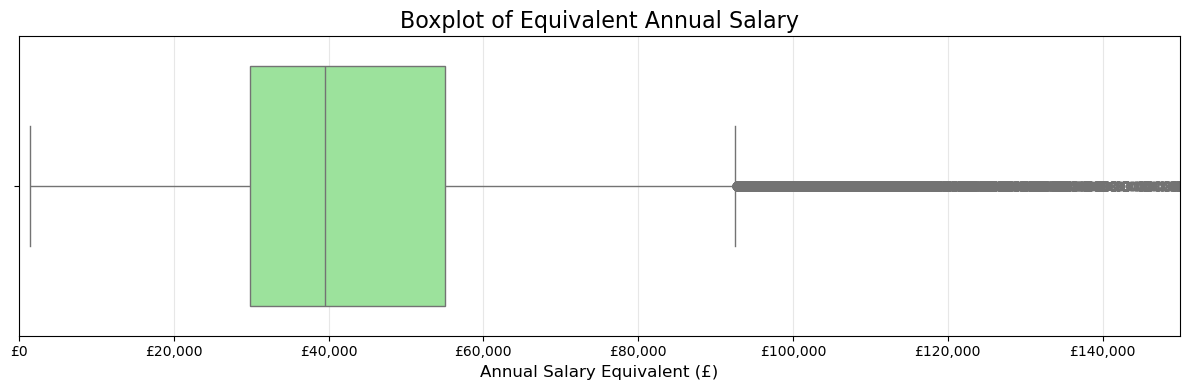

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's get some statistics on our current equivalent_annual_salary
# to help us define reasonable thresholds
stats = combined_df['equivalent_annual_salary'].describe()
print("Current salary statistics:")
print(stats)

# Define the transformation function with appropriate thresholds
def calculate_annual_equivalent(salary_value):
    if pd.isna(salary_value):
        return np.nan
    
    # Clearly hourly rate (below £100)
    if salary_value < 100:
        # Hourly rate: 40 hours × 52 weeks = 2,080 hours per year
        return salary_value * 2080
    
    # Likely daily rate (between £100 and £1,000)
    elif salary_value >= 100 and salary_value <= 1000:
        # Daily rate: 5 days × 52 weeks = 260 working days per year
        return salary_value * 260
    
    # Already an annual salary (above £1,000)
    else:
        # Cap extremely high values that may be errors
        if salary_value > 250000:
            return np.nan
        return salary_value

# Apply the transformation
combined_df['equivalent_annual_salary'] = combined_df['equivalent_annual_salary'].apply(calculate_annual_equivalent)

# Display the updated results
print("\nUpdated equivalent annual salaries:")
print(combined_df[['salary', 'equivalent_annual_salary']].head(10))

# Visualize the distribution
plt.figure(figsize=(12, 6))

# Get the UK National Minimum Wage values (hourly rates × 2080 hours)
# 2023: £10.42 per hour for adults aged 23+
# 2024: £11.44 per hour for adults aged 21+
# 2025: Estimated at £12.10 per hour based on trends
min_wage_2023 = 10.42 * 2080  # = £21,674
min_wage_2024 = 11.44 * 2080  # = £23,795
min_wage_2025 = 12.10 * 2080  # = £25,168

# Create a histogram with KDE overlay
salary_data = combined_df['equivalent_annual_salary'].dropna()
ax = sns.histplot(salary_data, kde=True, color='skyblue', bins=30)

# Add vertical lines for minimum wages
plt.axvline(x=min_wage_2023, color='red', linestyle='--', label='UK Min Wage 2023 (£21,674)')
plt.axvline(x=min_wage_2024, color='green', linestyle='--', label='UK Min Wage 2024 (£23,795)')
plt.axvline(x=min_wage_2025, color='purple', linestyle='--', label='Est. Min Wage 2025 (£25,168)')

# Add a rug plot at the bottom to show the actual data points
sns.rugplot(salary_data, color='darkblue', alpha=0.3, ax=ax)

# Add annotations for the thresholds we used in our transformation
plt.annotate('Hourly → Annual\n(× 2080 hrs)', xy=(50, 0), xytext=(50, ax.get_ylim()[1]*0.7),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
plt.annotate('Daily → Annual\n(× 260 days)', xy=(500, 0), xytext=(500, ax.get_ylim()[1]*0.8),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Calculate statistics for the annotation
mean_salary = salary_data.mean()
median_salary = salary_data.median()
stats_text = f"Mean: £{mean_salary:,.2f}\nMedian: £{median_salary:,.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Add titles and labels
plt.title('Distribution of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Annual Salary Equivalent (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Format x-axis with commas for thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Adjust limits to focus on the meaningful part of the distribution
plt.xlim(0, 150000)

# Add grid lines for better readability
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Let's also create a boxplot to visualize outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=salary_data, orient='h', color='lightgreen')
plt.title('Boxplot of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Annual Salary Equivalent (£)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 150000)
plt.tight_layout()
plt.show()

Remove jobs (or at least their salary as 'missing') for jobs with an ASE of less than the 2023 minimum wage.

Data points lost: 6968 (3.05% of the data)
Before filtering - 25th percentile: £29,840.00
After filtering - 25th percentile: £30,000.00
Before filtering - 50th percentile: £39,520.00
After filtering - 50th percentile: £40,000.00
Before filtering - 75th percentile: £55,000.00
After filtering - 75th percentile: £56,313.00


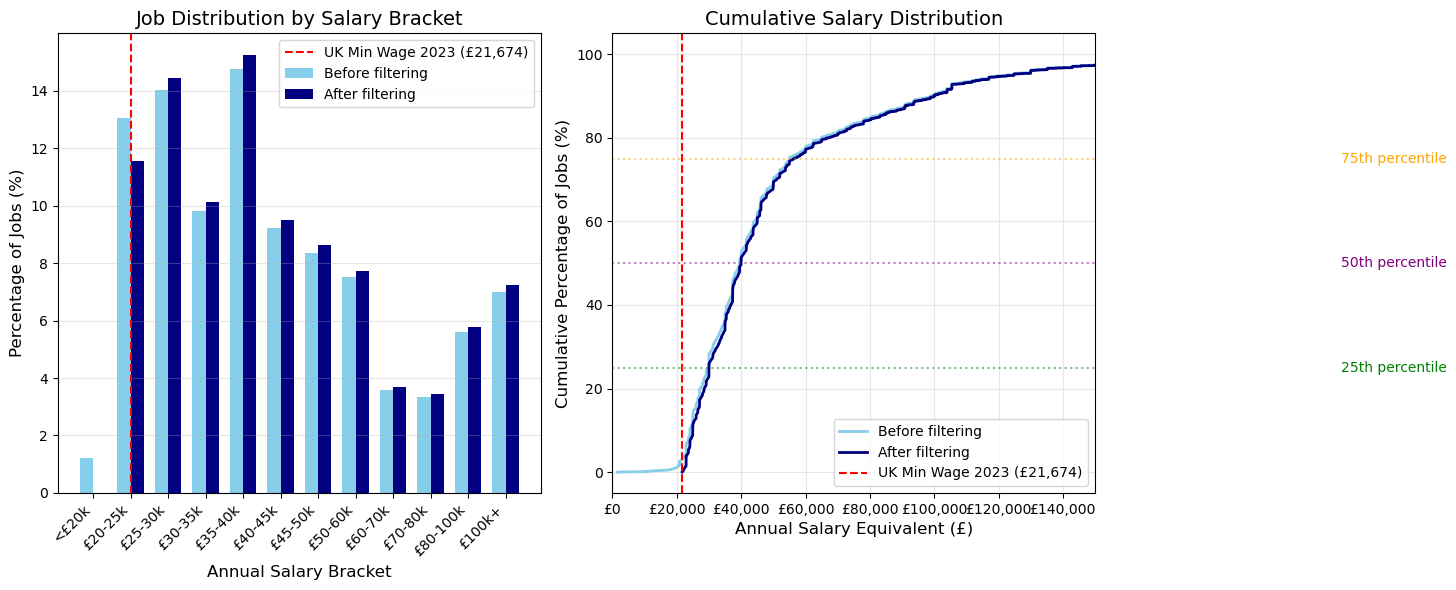


Before filtering - Median: £39,520.00, Mean: £51,106.33
After filtering - Median: £40,000.00, Mean: £52,118.33


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the 2023 UK minimum wage annual equivalent
min_wage_2023 = 10.42 * 2080  # = £21,674

# First, create the filtered_annual_salary column
# Make a copy of the equivalent_annual_salary column
combined_df['filtered_annual_salary'] = combined_df['equivalent_annual_salary'].copy()

# Replace values below minimum wage with NaN
combined_df.loc[combined_df['filtered_annual_salary'] < min_wage_2023, 'filtered_annual_salary'] = np.nan

# Now get the data for analysis
before_filtering = combined_df['equivalent_annual_salary'].dropna()
after_filtering = combined_df['filtered_annual_salary'].dropna()

# Count how many entries we have before and after filtering
total_before = before_filtering.count()
total_after = after_filtering.count()
points_lost = total_before - total_after
percentage_lost = (points_lost / total_before) * 100 if total_before > 0 else 0

print(f"Data points lost: {points_lost} ({percentage_lost:.2f}% of the data)")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Percentage of jobs by salary bracket
# Create salary brackets
brackets = [0, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 80000, 100000, 150000]
bracket_labels = ['<£20k', '£20-25k', '£25-30k', '£30-35k', '£35-40k', '£40-45k', 
                 '£45-50k', '£50-60k', '£60-70k', '£70-80k', '£80-100k', '£100k+']

# Calculate percentage in each bracket for both distributions
before_counts = pd.cut(before_filtering, bins=brackets).value_counts().sort_index()
before_percent = before_counts / total_before * 100

after_counts = pd.cut(after_filtering, bins=brackets).value_counts().sort_index()
after_percent = after_counts / total_after * 100

# Plot the percentage bars
x = np.arange(len(bracket_labels))
width = 0.35
ax1.bar(x - width/2, before_percent, width, label='Before filtering', color='skyblue')
ax1.bar(x + width/2, after_percent, width, label='After filtering', color='navy')

# Add reference line for min wage
min_wage_bracket_index = next((i for i, b in enumerate(brackets) if b > min_wage_2023)) - 1
ax1.axvline(x=min_wage_bracket_index, color='red', linestyle='--', 
           label=f'UK Min Wage 2023 (£{min_wage_2023:,.0f})')

# Customize plot 1
ax1.set_xlabel('Annual Salary Bracket', fontsize=12)
ax1.set_ylabel('Percentage of Jobs (%)', fontsize=12)
ax1.set_title('Job Distribution by Salary Bracket', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(bracket_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Cumulative distribution
# Sort the data
before_sorted = np.sort(before_filtering)
after_sorted = np.sort(after_filtering)

# Calculate cumulative distributions (percentiles)
before_y = np.arange(1, len(before_sorted) + 1) / len(before_sorted) * 100
after_y = np.arange(1, len(after_sorted) + 1) / len(after_sorted) * 100

# Plot cumulative distributions
ax2.plot(before_sorted, before_y, label='Before filtering', color='skyblue', linewidth=2)
ax2.plot(after_sorted, after_y, label='After filtering', color='navy', linewidth=2)

# Add reference line for min wage
ax2.axvline(x=min_wage_2023, color='red', linestyle='--', 
           label=f'UK Min Wage 2023 (£{min_wage_2023:,.0f})')

# Add annotations for key percentiles
percentiles = [25, 50, 75]
colors = ['green', 'purple', 'orange']
for i, p in enumerate(percentiles):
    before_val = np.percentile(before_filtering, p)
    after_val = np.percentile(after_filtering, p)
    
    # Plot horizontal lines at percentiles
    ax2.axhline(y=p, color=colors[i], linestyle=':', alpha=0.5)
    
    # Add annotations
    ax2.text(ax2.get_xlim()[1]*0.95, p, f'{p}th percentile', 
             color=colors[i], va='center', ha='right')
    
    # Print values
    print(f"Before filtering - {p}th percentile: £{before_val:,.2f}")
    print(f"After filtering - {p}th percentile: £{after_val:,.2f}")

# Customize plot 2
ax2.set_xlabel('Annual Salary Equivalent (£)', fontsize=12)
ax2.set_ylabel('Cumulative Percentage of Jobs (%)', fontsize=12)
ax2.set_title('Cumulative Salary Distribution', fontsize=14)
ax2.set_xlim(0, 150000)
ax2.grid(alpha=0.3)
ax2.legend(loc='lower right')

# Format x-axis with commas for thousands
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\nBefore filtering - Median: £{before_filtering.median():,.2f}, Mean: £{before_filtering.mean():,.2f}")
print(f"After filtering - Median: £{after_filtering.median():,.2f}, Mean: £{after_filtering.mean():,.2f}")

# Step 6. Jobs

## 6.1 Find most common words and phrases to base a dictionary on

Top 20 Unigrams (Single Words):
Word                 Count      Percentage
----------------------------------------
nurse                65528      8.32%
care                 27745      3.52%
registered           22989      2.92%
manager              22989      2.92%
assistant            22472      2.85%
health               15934      2.02%
senior               15375      1.95%
clinical             14930      1.90%
practitioner         13422      1.70%
therapist            13354      1.70%
home                 12158      1.54%
occupational         11409      1.45%
dentist              9055       1.15%
specialist           8889       1.13%
band                 8747       1.11%
worker               8541       1.08%
staff                8312       1.06%
support              8078       1.03%
lead                 7832       0.99%
mental               7323       0.93%

Top 20 Bigrams (Two-Word Combinations):
Bigram                                   Count      Percentage
--------------------

C:\Users\lslater2\AppData\Local\Temp\1\ipykernel_1816\2131811679.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unigram_counts, y=unigram_words, ax=axes[0], palette='viridis')
C:\Users\lslater2\AppData\Local\Temp\1\ipykernel_1816\2131811679.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_phrases, ax=axes[1], palette='viridis')
C:\Users\lslater2\AppData\Local\Temp\1\ipykernel_1816\2131811679.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trigram_counts, y=trigram_phrases, ax=axes[2], palette='

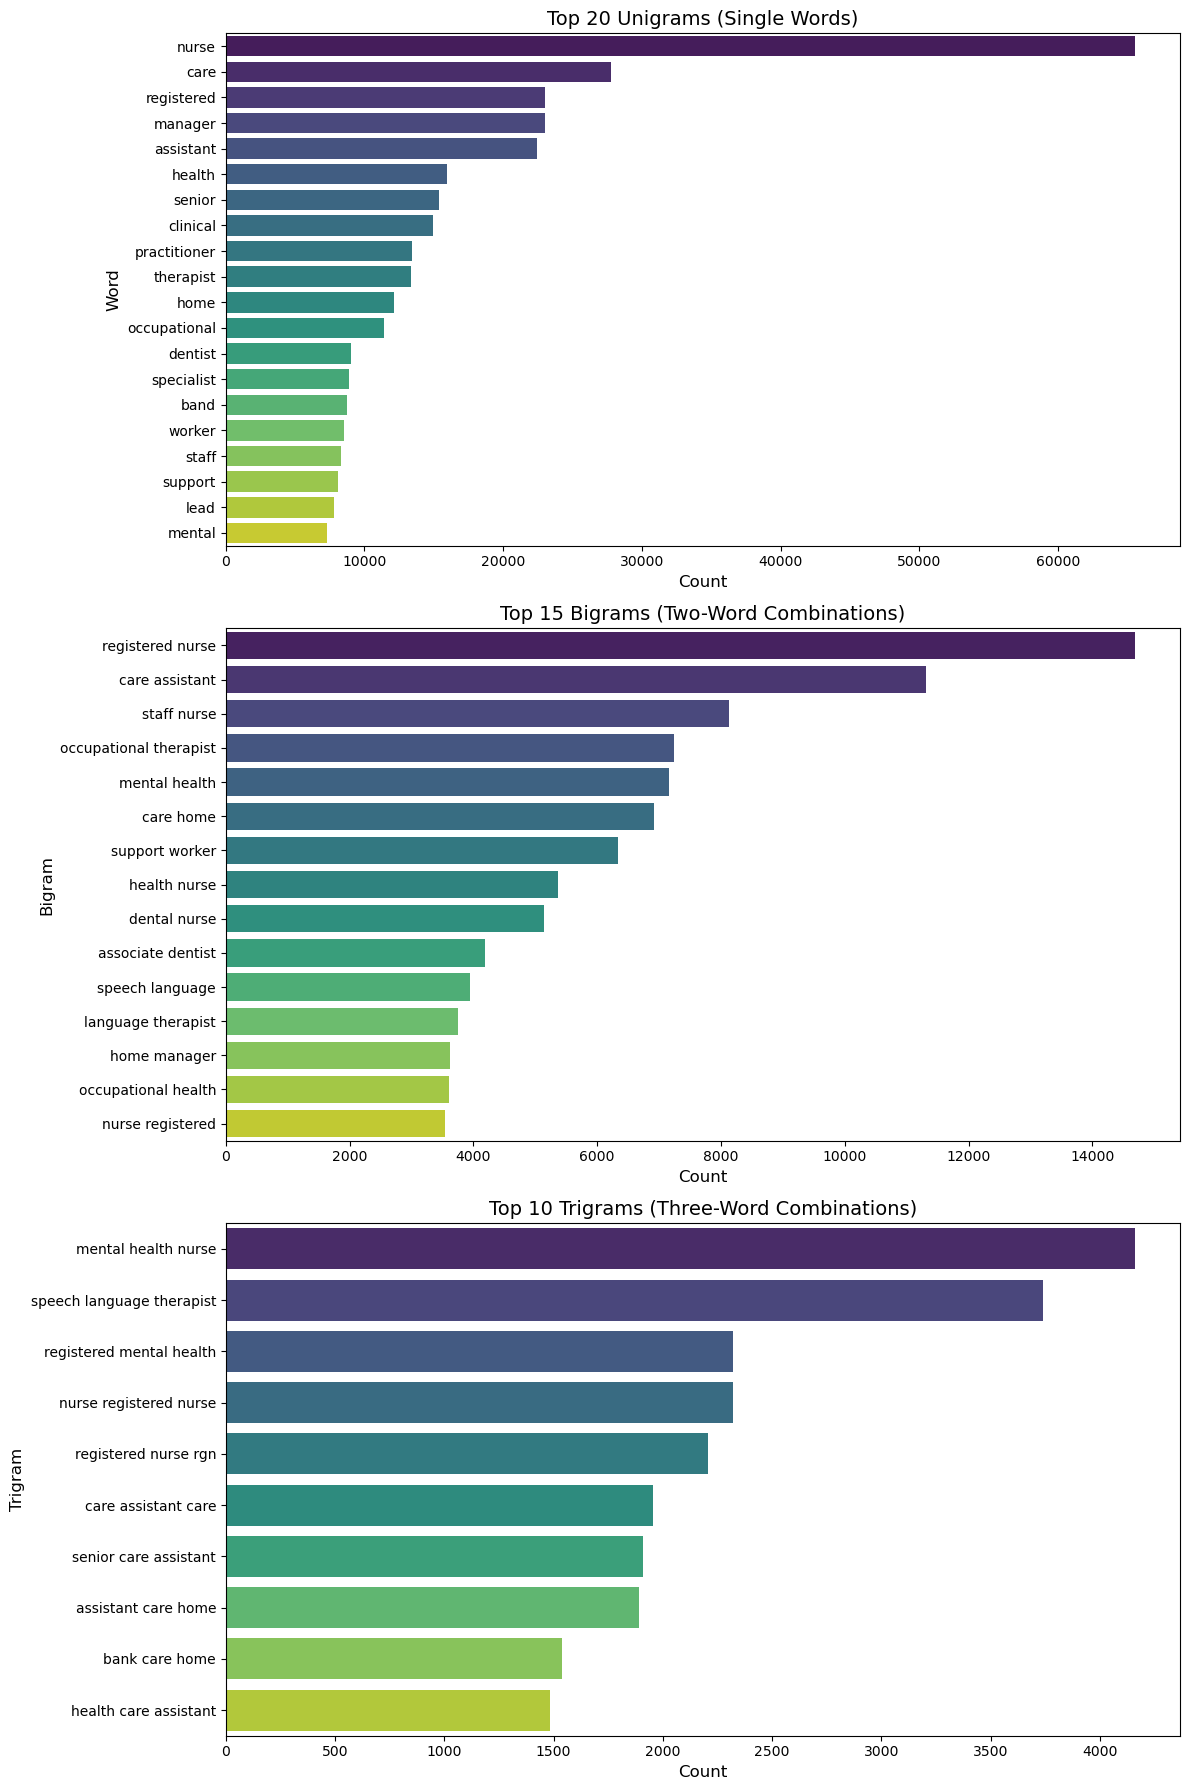

In [61]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define our own simple stopwords list
STOPWORDS = {
    'a', 'an', 'the', 'and', 'or', 'but', 'if', 'because', 'as', 'what',
    'which', 'this', 'that', 'these', 'those', 'then', 'just', 'so', 'than',
    'such', 'both', 'through', 'about', 'for', 'is', 'of', 'while', 'during',
    'to', 'from', 'in', 'on', 'at', 'by', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'up',
    'down', 'not', 'no', 'it', 'its', 'we', 'us', 'our', 'they', 'them', 'their'
}

# Function to preprocess text without NLTK
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    
    # Convert to lowercase and replace punctuation with spaces
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Tokenize (split on whitespace)
    tokens = text.split()
    
    # Remove stopwords and numbers, and ensure words are at least 2 characters
    tokens = [word for word in tokens if word not in STOPWORDS and not word.isdigit() and len(word) >= 2]
    
    return tokens

# Function to extract n-grams
def get_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Apply preprocessing to each title
all_tokens = []
for title in combined_df['title'].dropna():
    all_tokens.extend(preprocess_text(title))

# Count unigrams (single words)
unigram_counts = Counter(all_tokens)
total_unigrams = sum(unigram_counts.values())

# Get top 20 unigrams
top_unigrams = unigram_counts.most_common(20)
unigram_percentages = [(word, count, count/total_unigrams*100) for word, count in top_unigrams]

# Process n-grams (bigrams, trigrams, quadgrams)
def get_top_ngrams(tokens, n, top_n=20):
    # Create n-grams
    n_grams = get_ngrams(tokens, n)
    
    # Count frequencies
    n_gram_counts = Counter(n_grams)
    total_ngrams = sum(n_gram_counts.values())
    
    # Get top n_grams
    top_n_grams = n_gram_counts.most_common(top_n)
    
    # Calculate percentages
    n_gram_percentages = [(gram, count, count/total_ngrams*100) for gram, count in top_n_grams]
    
    return n_gram_percentages

# Get text as token lists for processing n-grams
all_title_tokens = []
for title in combined_df['title'].dropna():
    processed = preprocess_text(title)
    if processed:  # Only add if not empty
        all_title_tokens.extend(processed)

# Get top n-grams
top_bigrams = get_top_ngrams(all_title_tokens, 2)
top_trigrams = get_top_ngrams(all_title_tokens, 3)
top_quadgrams = get_top_ngrams(all_title_tokens, 4)

# Print results
print("Top 20 Unigrams (Single Words):")
print(f"{'Word':<20} {'Count':<10} {'Percentage':<10}")
print("-" * 40)
for word, count, percentage in unigram_percentages:
    print(f"{word:<20} {count:<10} {percentage:.2f}%")

print("\nTop 20 Bigrams (Two-Word Combinations):")
print(f"{'Bigram':<40} {'Count':<10} {'Percentage':<10}")
print("-" * 60)
for gram, count, percentage in top_bigrams:
    print(f"{' '.join(gram):<40} {count:<10} {percentage:.2f}%")

print("\nTop 20 Trigrams (Three-Word Combinations):")
print(f"{'Trigram':<60} {'Count':<10} {'Percentage':<10}")
print("-" * 80)
for gram, count, percentage in top_trigrams:
    print(f"{' '.join(gram):<60} {count:<10} {percentage:.2f}%")

print("\nTop 20 Quadgrams (Four-Word Combinations):")
print(f"{'Quadgram':<80} {'Count':<10} {'Percentage':<10}")
print("-" * 100)
for gram, count, percentage in top_quadgrams:
    print(f"{' '.join(gram):<80} {count:<10} {percentage:.2f}%")

# Visualize the top unigrams, bigrams, and trigrams
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot unigrams
unigram_words = [word for word, _, _ in unigram_percentages]
unigram_counts = [count for _, count, _ in unigram_percentages]
sns.barplot(x=unigram_counts, y=unigram_words, ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Unigrams (Single Words)', fontsize=14)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Word', fontsize=12)

# Plot bigrams
bigram_phrases = [' '.join(gram) for gram, _, _ in top_bigrams[:15]]  # Limit to 15 for readability
bigram_counts = [count for _, count, _ in top_bigrams[:15]]
sns.barplot(x=bigram_counts, y=bigram_phrases, ax=axes[1], palette='viridis')
axes[1].set_title('Top 15 Bigrams (Two-Word Combinations)', fontsize=14)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Bigram', fontsize=12)

# Plot trigrams
trigram_phrases = [' '.join(gram) for gram, _, _ in top_trigrams[:10]]  # Limit to 10 for readability
trigram_counts = [count for _, count, _ in top_trigrams[:10]]
sns.barplot(x=trigram_counts, y=trigram_phrases, ax=axes[2], palette='viridis')
axes[2].set_title('Top 10 Trigrams (Three-Word Combinations)', fontsize=14)
axes[2].set_xlabel('Count', fontsize=12)
axes[2].set_ylabel('Trigram', fontsize=12)

plt.tight_layout()
plt.show()

## 6.2. Recode job titles and find most common others

Job Title Category Distribution:
job_title_category
nurse_other            34648
registered_nurse       21001
manager                19087
care_assistant         18477
therapist              18299
healthcare_other       15380
support_staff          15116
doctor                 13087
other                  12012
dentist                11940
pharmacy                6773
mental_health           4778
psychology              4528
coordinator             3789
assessor                3211
supervision             3083
occupational_health     3034
radiology               2862
fitness                 2785
optometry               2775
specialist              2685
home_care               1919
scientist               1290
paramedic                991
midwifery                900
dietetics                784
cardiac                  655
audiology                477
podiatry                 436
respiratory              385
social_work              383
hospitality              375
phlebotomy          

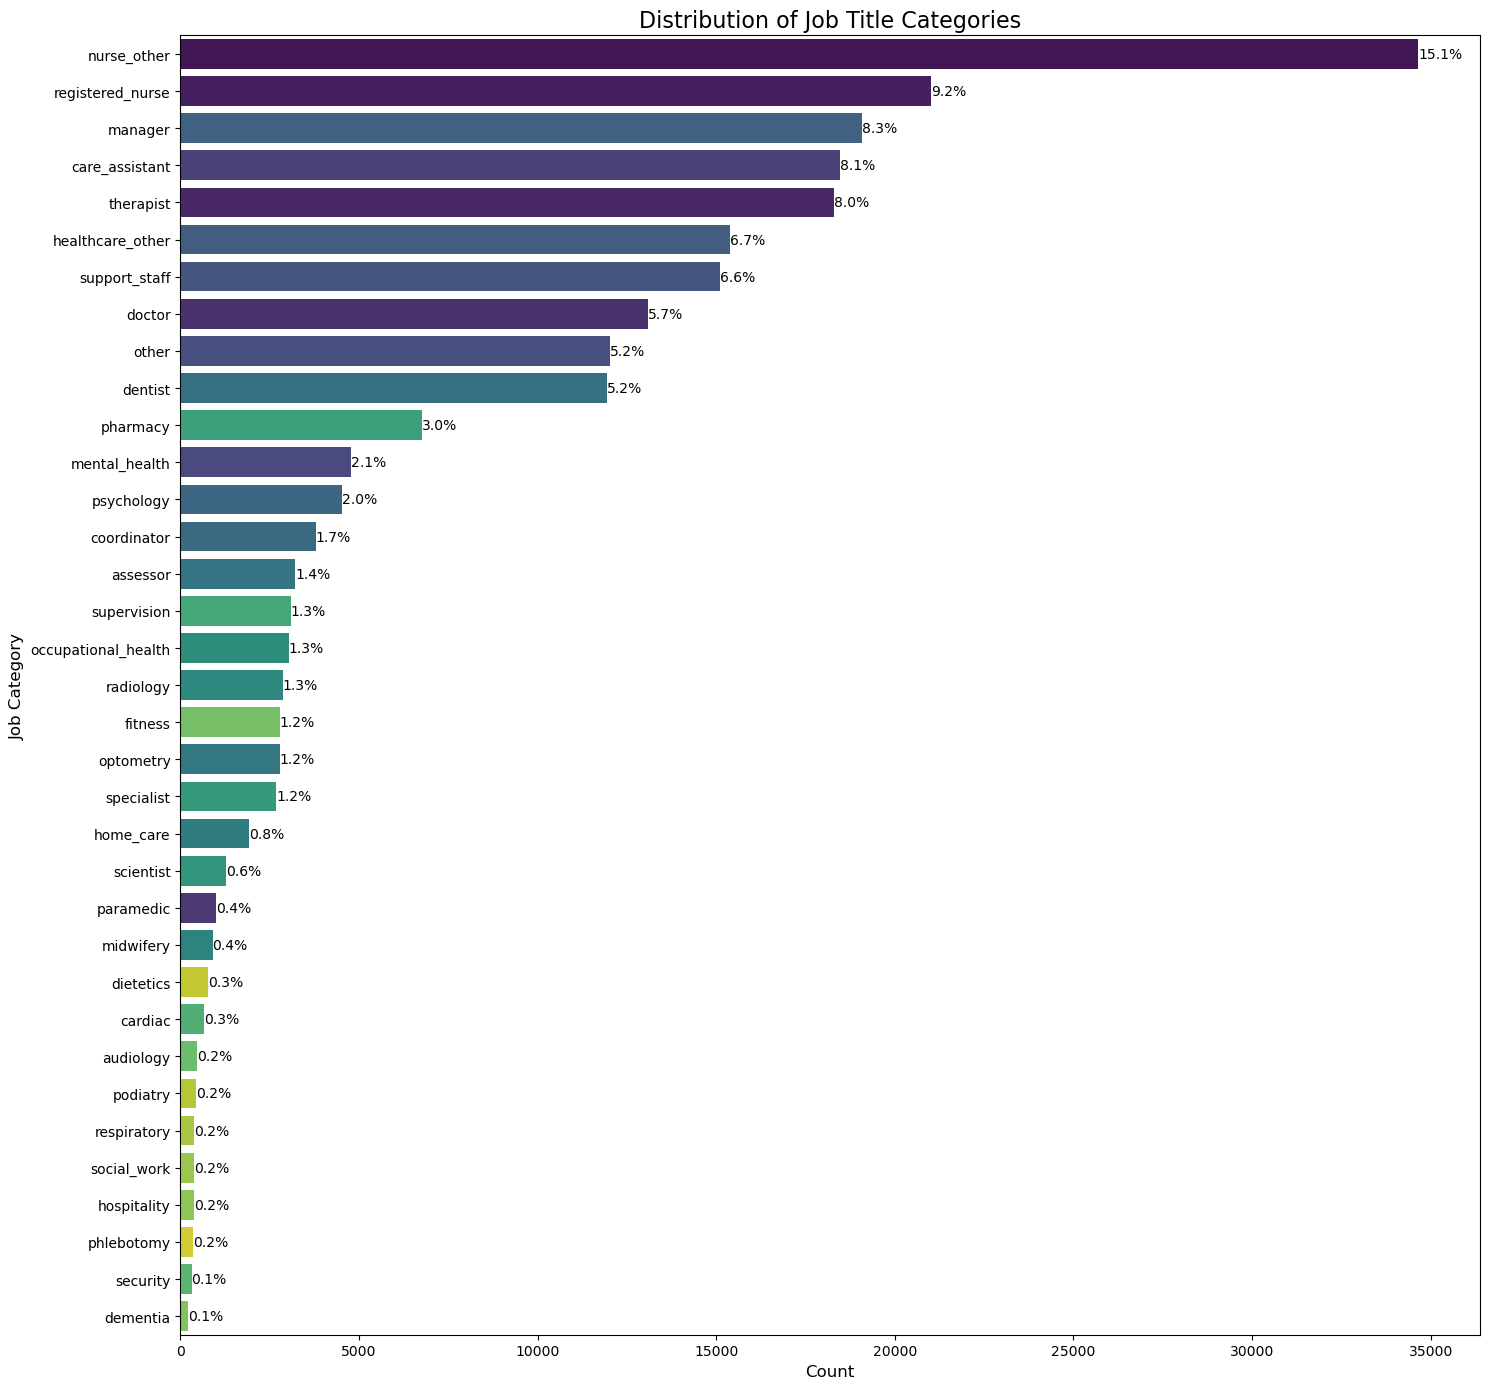

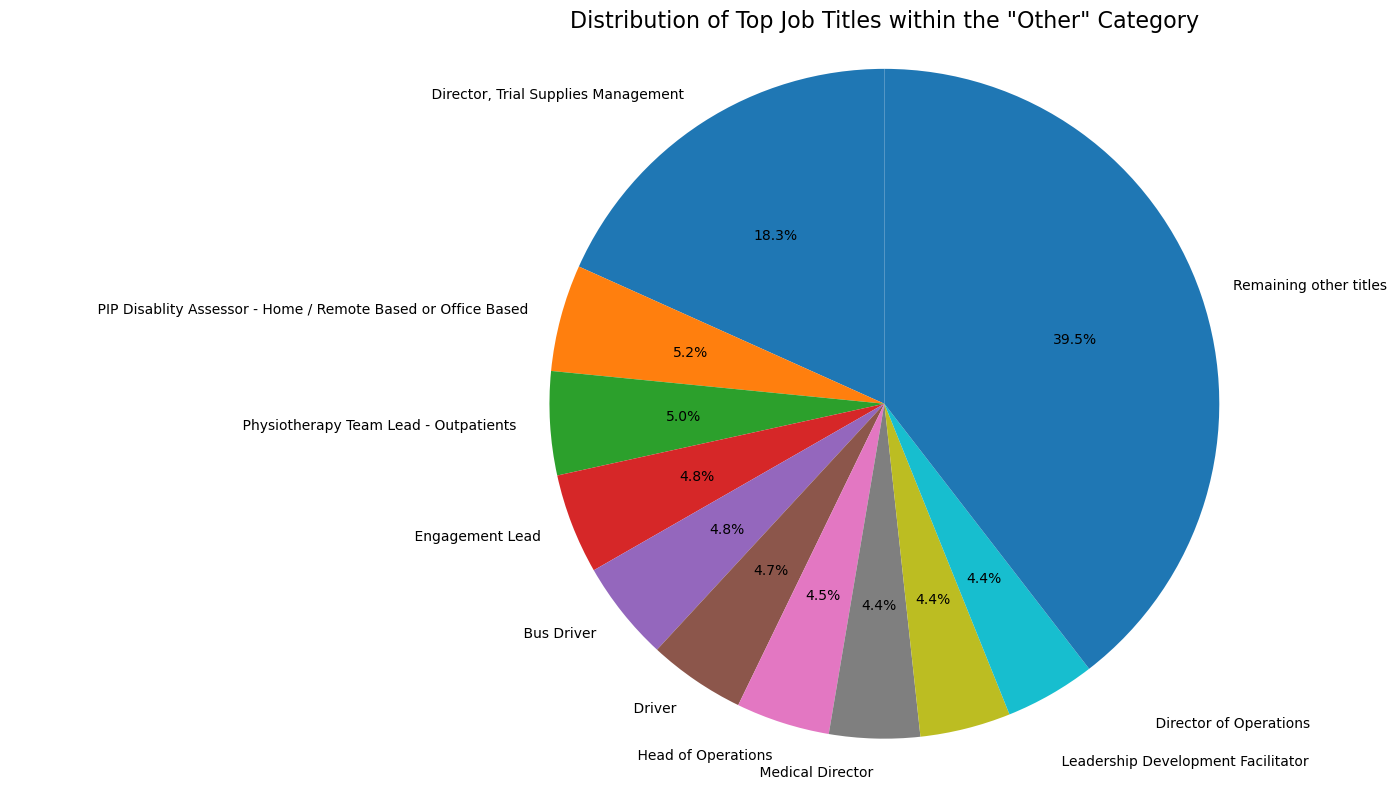


Salary Statistics by Job Category:
                     count      min       max   median          mean  missing_percent
job_title_category                                                                   
doctor               12620  21678.0  260000.0  93666.0  92251.285737              3.6
optometry             2725  21711.0  182000.0  72800.0  82964.248073              1.8
dentist              11432  21697.0  249600.0  62400.0  86987.549685              4.3
psychology            4496  21831.0  231400.0  53755.0  66304.903692              0.7
manager              19007  21709.0  247000.0  47840.0  58586.036671              0.4
cardiac                651  23362.0  170300.0  46148.0  56534.812596              0.6
pharmacy              6603  21698.0  195000.0  45000.0  47771.431168              2.5
specialist            2665  22000.0  247000.0  44806.0  58742.713321              0.7
home_care             1842  22801.0  257400.0  44648.0  62648.878393              4.0
registered_nurse  

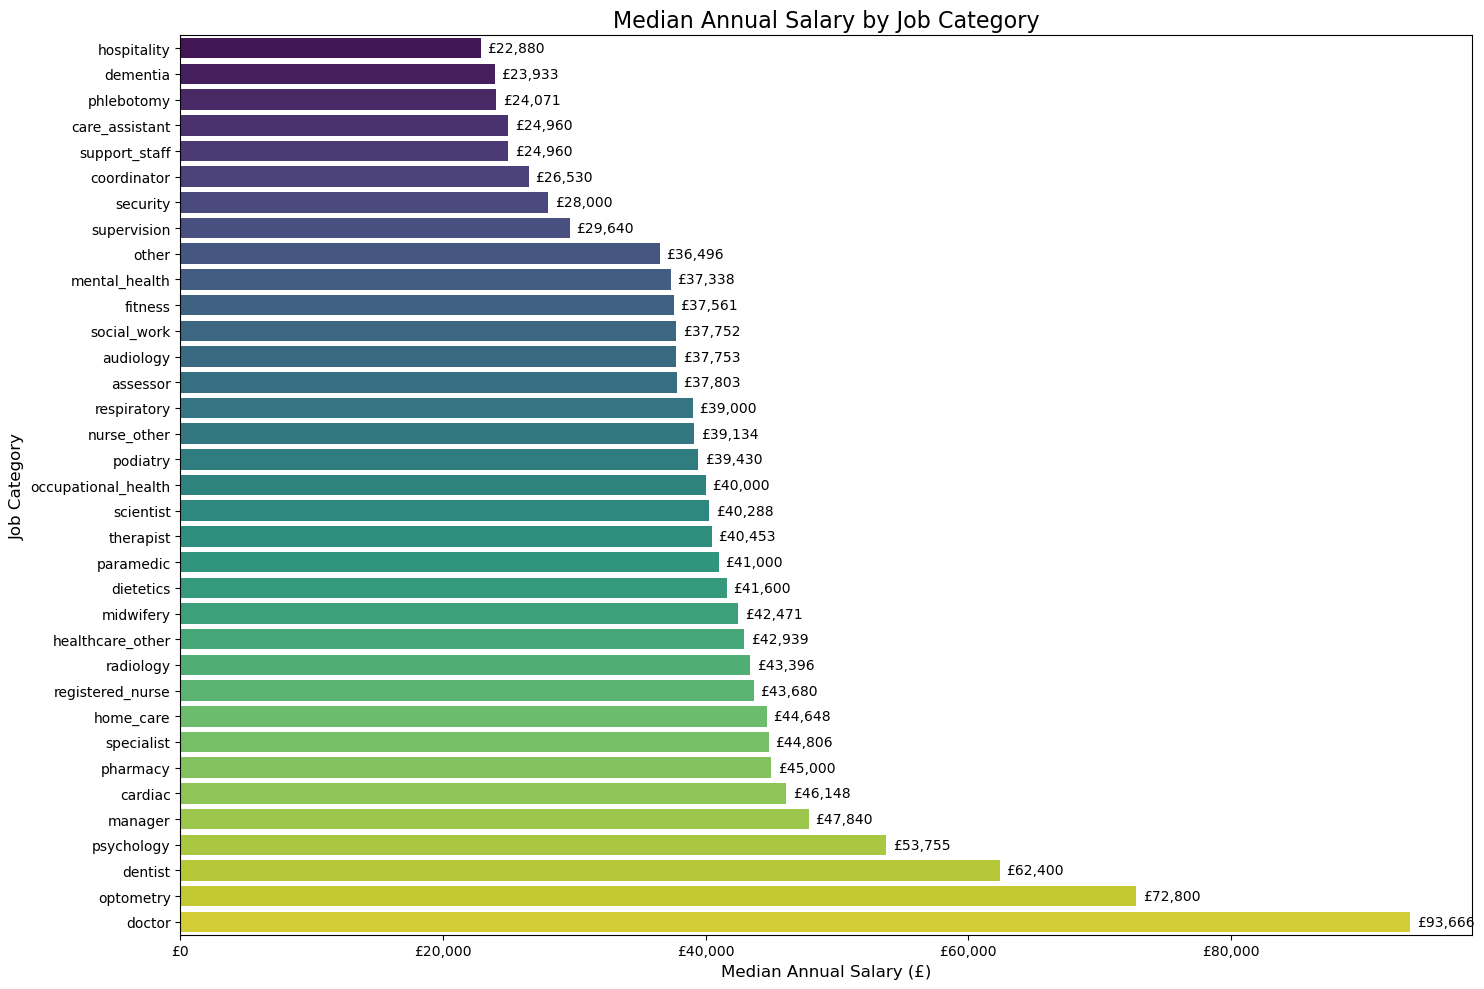

In [62]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Final comprehensive dictionary for healthcare job title classification
job_title_dict = {
    # Nursing categories
    'registered_nurse': [
        'registered nurse', 'rn', 'nurse registered', 'rgn', 'registered mental health nurse',
        'registered general nurse', 'nurse rgn', 'rmn', 'registered midwife', 'nursing associate',
        'registered nursing', 'nurse register', 'matron'
    ],
    'nurse_other': [
        'staff nurse', 'nurse', 'health nurse', 'dental nurse', 'nurse practitioner',
        'practice nurse', 'community nurse', 'district nurse', 'school nurse',
        'nursery nurse', 'veterinary nurse', 'clinic nurse', 'charge nurse',
        'oncology nurse', 'primary care nurse', 'bank nurse', 'specialist nurse',
        'deputy nurse', 'vet nurse', 'adult nurse', 'nurse manager', 'deputy charge',
        'legal nurse', 'clinical nurse advisor'
    ],
    
    # Care roles
    'care_assistant': [
        'care assistant', 'care worker', 'healthcare assistant', 'hca', 'support worker',
        'care support', 'care support worker', 'senior care assistant', 'carer',
        'night senior carer', 'senior carer', 'recovery worker', 'recovery navigator',
        'health and wellbeing', 'care planner', 'head of care'
    ],
    'home_care': [
        'care home', 'home care', 'assistant care home', 'bank care home', 'home manager',
        'home carer', 'domiciliary care', 'domiciliary carer', 'deputy care home',
        'maintenance assistant care home', 'hub manager home care', 'senior nurse care home'
    ],
    
    # Medical professionals
    'doctor': [
        'doctor', 'gp', 'general practitioner', 'medical doctor', 'physician',
        'consultant', 'surgeon', 'medical officer', 'anaesthetist', 'gastroenterologist',
        'rheumatologist', 'psychiatrist', 'specialist doctor', 'plastic surgeon',
        'lead clinician', 'non-medical prescriber', 'vet surgeon', 'ent consultant',
        'non medical prescriber', 'orthodontist', 'periodontist'
    ],
    'dentist': [
        'dentist', 'dental', 'associate dentist', 'dental surgeon', 'dental hygienist',
        'trainee dental nurse', 'dental receptionist', 'qualified dental nurse',
        'endodontist'
    ],
    
    # Therapy roles
    'mental_health': [
        'mental health', 'mental health nurse', 'mental health worker', 'mental health practitioner',
        'psychiatric', 'psychological wellbeing practitioner', 'senior mental health',
        'crisis team', 'crht', 'psychiatric nurse', 'counsellor'
    ],
    'therapist': [
        'therapist', 'occupational therapist', 'speech language therapist', 'speech therapist',
        'physiotherapist', 'physical therapist', 'language therapist', 'rehabilitation',
        'speech and language', 'locum occupational therapist', 'specialist occupational therapist',
        'apprentice occupational therapist', 'deputy head of occupational therapy', 'therapy worker'
    ],
    
    # Management roles
    'manager': [
        'manager', 'home manager', 'clinical manager', 'practice manager', 'care manager',
        'service manager', 'team manager', 'clinic manager', 'registered manager',
        'deputy manager', 'supported living manager', 'pharmacist manager', 'pharmacy manager',
        'deputy ward manager', 'ward manager', 'hospital director', 'deputy hospital director',
        'vendor manager', 'general manager'
    ],
    
    # Other healthcare professionals
    'healthcare_other': [
        'healthcare', 'health care', 'health professional', 'health worker', 'health assistant',
        'clinical', 'practitioner', 'band', 'health service', 'clinical lead',
        'theatre practitioner', 'health visitor', 'emhp supervisor', 'mhst specialist',
        'theatre clinical', 'quality lead', 'assistant practitioner', 'health advisor',
        'clean room supervisor', 'pre-registration', 'advanced clinical practitioner',
        'transformation', 'clinical nurse', 'clinical transformation', 'trainee health screener'
    ],
    
    # Miscellaneous support roles
    'support_staff': [
        'support worker', 'support', 'staff', 'assistant', 'administrator', 'receptionist',
        'secretary', 'clerical', 'service administrator', 'administration assistant',
        'pharmacy assistant', 'trainee it support', 'bank support', 'accounts assistant',
        'porter', 'housekeeper', 'therapy assistant', 'laundry assistant', 'sterile services',
        'decontamination technician', 'technician', 'optical assistant', 'female support',
        'ward clerk', 'maintenance operative', 'chef', 'cook'
    ],
    
    # Previously added categories
    'optometry': [
        'optometrist', 'dispensing optician', 'optician', 'optical colleague'
    ],
    'pharmacy': [
        'pharmacist', 'pharmacy technician', 'pharmacy dispenser', 'clinical pharmacist',
        'pharmacy colleague', 'dispenser', 'lead clinical pharmacist', 'bank pharmacy'
    ],
    'occupational_health': [
        'occupational health advisor', 'occupational health nurse', 'occupational health technician',
        'occupational health trainee', 'lead occupational health', 'corporate wellbeing advisor'
    ],
    'fitness': [
        'wellbeing personal trainer', 'personal trainer', 'fitness', 'level 3 qualified personal trainer',
        'fitness professional', 'self employed personal trainer'
    ],
    'assessor': [
        'functional assessor', 'disability assessor', 'pip assessor', 'paramedic disability assessor',
        'paramedic functional assessor', 'pip disability assessor', 'remote assessor'
    ],
    'coordinator': [
        'care coordinator', 'activities coordinator', 'coordinator', 'activity co-ordinator',
        'recovery coordinator', 'patient flow coordinator', 'lifestyle co-ordinator',
        'care co-ordinator', 'activities co-ordinator', 'pcn and care homes care co-ordinator',
        'nurse care coordinator', 'care plan coordinator'
    ],
    'radiology': [
        'radiographer', 'radiologist', 'radiology', 'senior radiographer', 'advanced radiographer',
        'mammographer', 'sonographer', 'bank radiology assistant', 'cross sectional',
        'bank mr radiographer', 'specialist radiographer', 'mri/ct radiographer'
    ],
    'psychology': [
        'psychologist', 'clinical psychologist', 'psychology', 'registered psychologist',
        'forensic psychologist', 'ld forensic', 'principal practitioner psychologist',
        'practitioner psychologist', 'principal psychologist'
    ],
    'supervision': [
        'team leader', 'field care supervisor', 'supervisor', 'cluster team leader',
        'hospital reception supervisor', 'mechanical supervisor', 'therapy team leader',
        'phlebotomy supervisor'
    ],
    'specialist': [
        'associate specialist', 'specialist', 'language and speech specialist', 
        'clinical nurse specialist', 'referrals hub clinical specialist', 'community paediatric specialist'
    ],
    'phlebotomy': [
        'phlebotomist', 'phlebotomy'
    ],
    'paramedic': [
        'paramedic', 'emergency nurse practitioner', 'prescribing paramedic',
        'anp', 'acp', 'nurse paramedic', 'primary care paramedic'
    ],
    'hospitality': [
        'hospitality', 'host', 'hostess'
    ],
    'dietetics': [
        'dietitian', 'dietetics', 'nutritionist', 'specialist dietitian',
        'community dietitian', 'paediatric dietitian', 'band 5/6 dietitian'
    ],
    'audiology': [
        'audiologist', 'audiology', 'paediatric audiologist', 'hearing aid audiologist'
    ],
    'dementia': [
        'dementia adviser', 'dementia care', 'dementia specialist', 'dementia ambassador'
    ],
    'podiatry': [
        'podiatrist', 'podiatry', 'specialist podiatrist', 'band 5 podiatrist', 
        'senior podiatrist'
    ],
    'security': [
        'prison custody officer', 'security', 'area security officer', 'relief security officer'
    ],
    'midwifery': [
        'midwife', 'midwifery', 'rotational midwife', 'community midwife', 'band 6 community',
        'maternity unit'
    ],
    'cardiac': [
        'cardiac physiologist', 'cardiac', 'cardiology', 'paediatric cardiology physiologist',
        'clinical fellow in cardiology', 'highly specialist cardiac'
    ],
    'scientist': [
        'biomedical scientist', 'scientist', 'laboratory', 'senior clinical scientist',
        'specialist biomedical scientist', 'cellular pathology', 'haematology'
    ],
    
    # New categories based on the latest "other" results
    'social_work': [
        'social worker', 'independent advocate', 'employment advisor'
    ],
    'respiratory': [
        'respiratory physiologist', 'respiratory'
    ]
}

# Function to classify job titles with enhanced logic
def classify_job_title(title):
    if pd.isna(title) or not isinstance(title, str):
        return 'unknown'
    
    # Convert to lowercase for matching
    title_lower = title.lower()
    
    # Set up a scoring system for each category
    category_scores = {}
    matched_patterns = {}
    
    # Check each category
    for category, patterns in job_title_dict.items():
        for pattern in patterns:
            if pattern in title_lower:
                # Add a score for this category (longer patterns get higher scores)
                score = len(pattern) * 2  # Weight by pattern length
                if category in category_scores:
                    category_scores[category] += score
                    matched_patterns[category].append(pattern)
                else:
                    category_scores[category] = score
                    matched_patterns[category] = [pattern]
    
    # If no matches found
    if not category_scores:
        return 'other'
    
    # Special case handling
    
    # If both registered_nurse and nurse_other match, prioritize registered_nurse
    if 'registered_nurse' in category_scores and 'nurse_other' in category_scores:
        if any('registered' in pattern for pattern in matched_patterns['registered_nurse']):
            return 'registered_nurse'
    
    # If both doctor and another category match
    if 'doctor' in category_scores:
        if any(category in category_scores for category in ['paramedic', 'nurse_other', 'registered_nurse']):
            # Check if the title has explicit doctor terms
            doctor_terms = ['doctor', 'gp', 'general practitioner', 'physician', 'consultant', 'surgeon']
            if any(term in title_lower for term in doctor_terms):
                return 'doctor'
    
    # Special case for midwife
    if 'midwife' in title_lower or 'midwifery' in title_lower:
        return 'midwifery'
    
    # Special case for nursing associate
    if 'nursing associate' in title_lower:
        return 'registered_nurse'
    
    # Special cases for dentists/orthodontists
    if any(term in title_lower for term in ['orthodontist', 'periodontist', 'endodontist']):
        return 'doctor'  # These are specialized dental doctors
    
    # Special case for occupational therapy management
    if 'deputy head of occupational therapy' in title_lower:
        return 'therapist'
    
    # Priority categories that should generally take precedence
    priority_categories = [
        'registered_nurse',    # Should take precedence over 'nurse_other'
        'doctor',              # Specific medical role
        'dentist',             # Specific medical role
        'midwifery',           # Specific medical role
        'paramedic',           # Specific medical role
        'optometry',           # Specific medical role
        'pharmacy',            # Specific medical role
        'mental_health',       # Specific healthcare role
        'therapist',           # Specific healthcare role
        'psychology',          # Specific healthcare role
        'radiology',           # Specific healthcare role
        'dietetics',           # Specific healthcare role
        'audiology',           # Specific healthcare role
        'podiatry',            # Specific healthcare role
        'phlebotomy',          # Specific healthcare role
        'cardiac',             # Specific healthcare role
        'scientist',           # Specific healthcare role
        'respiratory',         # Specific healthcare role
        'social_work'          # Specific healthcare role
    ]
    
    # Check if any priority categories have matches
    for category in priority_categories:
        if category in category_scores:
            # For priority categories, check if the match is strong enough
            top_score = max(category_scores.values())
            if category_scores[category] >= top_score * 0.8:  # At least 80% of the top score
                return category
    
    # Get the top scoring category
    top_category = sorted(category_scores.items(), key=lambda x: x[1], reverse=True)[0][0]
    
    # Some final special cases:
    
    # If care_assistant and support_staff both match, choose based on specific terms
    if 'care_assistant' in category_scores and 'support_staff' in category_scores:
        care_terms = ['care assistant', 'care worker', 'carer', 'hca']
        if any(term in title_lower for term in care_terms):
            return 'care_assistant'
    
    # Special case for therapy worker
    if 'therapy worker' in title_lower:
        return 'therapist'
    
    # Final decision: return the category with the highest score
    return top_category

# Apply the classification to the DataFrame
combined_df['job_title_category'] = combined_df['title'].apply(classify_job_title)

# Get counts for each category to see the distribution
job_category_counts = combined_df['job_title_category'].value_counts()
print("Job Title Category Distribution:")
print(job_category_counts)
print("\nPercentage Distribution:")
print(job_category_counts / len(combined_df) * 100)

# Sample titles from each category to verify classification
print("\nSample job titles from each category:")
for category in job_category_counts.index:
    if category != 'other':  # We'll handle 'other' separately
        samples = combined_df[combined_df['job_title_category'] == category]['title'].sample(min(3, sum(combined_df['job_title_category'] == category))).tolist()
        print(f"\n{category.upper()}:")
        for sample in samples:
            print(f"  - {sample}")

# Analyze the 'other' category in more detail
other_titles = combined_df[combined_df['job_title_category'] == 'other']['title']
total_other = len(other_titles)

# Count frequency of each unique title in the 'other' category
other_title_counts = other_titles.value_counts().head(20)  # Top 20 most common 'other' titles
other_title_percentages = (other_title_counts / total_other * 100).round(2)

print("\nTOP 20 MOST COMMON JOB TITLES IN 'OTHER' CATEGORY:")
print(f"{'Job Title':<40} {'Count':<10} {'% of Other':<15} {'% of Total':<15}")
print("-" * 80)
for title, count in other_title_counts.items():
    percent_of_other = other_title_percentages[title]
    percent_of_total = count / len(combined_df) * 100
    print(f"{title:<40} {count:<10} {percent_of_other:<15.2f} {percent_of_total:<15.2f}")

# Create a visualization of the job title categories
plt.figure(figsize=(15, 14))
ax = sns.countplot(
    y='job_title_category', 
    data=combined_df,
    order=job_category_counts.index, 
    palette='viridis',
    hue='job_title_category',  # Fix the FutureWarning by setting hue properly
    legend=False  # No need for a legend since hue is the same as y
)
plt.title('Distribution of Job Title Categories', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Job Category', fontsize=12)

# Add percentage labels
for i, count in enumerate(job_category_counts):
    percentage = count / len(combined_df) * 100
    ax.text(count + 0.5, i, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

# Create a pie chart for the 'other' category distribution
plt.figure(figsize=(12, 8))
other_for_pie = other_title_counts.copy()
if len(other_for_pie) > 10:
    # Combine all beyond the top 10 into an "Other within Other" category
    other_within_other = pd.Series({'Remaining other titles': other_for_pie[10:].sum()})
    other_for_pie = pd.concat([other_for_pie[:10], other_within_other])

plt.pie(other_for_pie, labels=other_for_pie.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Top Job Titles within the "Other" Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

# Create a function to get salary statistics by job category
def analyze_salaries_by_job_category():
    # Group by job category and calculate salary statistics
    salary_stats = combined_df.groupby('job_title_category')['filtered_annual_salary'].agg([
        ('count', 'count'),
        ('min', 'min'),
        ('max', 'max'),
        ('median', 'median'),
        ('mean', 'mean')
    ]).sort_values(by='median', ascending=False)
    
    # Calculate percentage of missing salaries by category
    total_by_category = combined_df.groupby('job_title_category').size()
    missing_by_category = combined_df.groupby('job_title_category')['filtered_annual_salary'].apply(
        lambda x: x.isna().sum()
    )
    percent_missing = (missing_by_category / total_by_category * 100).round(1)
    
    # Add percentage missing to the stats
    salary_stats['missing_percent'] = percent_missing
    
    return salary_stats

# Print salary statistics by job category
print("\nSalary Statistics by Job Category:")
try:
    salary_stats = analyze_salaries_by_job_category()
    print(salary_stats)
    
    # Create a visualization of median salaries by job category
    plt.figure(figsize=(15, 10))
    
    # Filter out categories with too few salary data points (e.g., < 10)
    valid_stats = salary_stats[salary_stats['count'] >= 10].sort_values(by='median')
    
    # Create a horizontal bar chart of median salaries
    ax = sns.barplot(
        x='median', 
        y=valid_stats.index, 
        data=valid_stats.reset_index(),
        palette='viridis',
        hue=valid_stats.index,
        legend=False
    )
    
    plt.title('Median Annual Salary by Job Category', fontsize=16)
    plt.xlabel('Median Annual Salary (£)', fontsize=12)
    plt.ylabel('Job Category', fontsize=12)
    
    # Format x-axis with commas for thousands
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    
    # Add median values as text labels
    for i, median in enumerate(valid_stats['median']):
        if not pd.isna(median):
            ax.text(median + 500, i, f'£{median:,.0f}', va='center')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error analyzing salaries: {e}")

In [63]:
# Get column names from the dataframe
column_names = combined_df.columns.tolist()

# Print the column names
print("Column names in combined_df:")
for i, col in enumerate(column_names, 1):
    print(f"{i}. {col}")

# Alternatively, just print the list directly
print("\nAll columns as a list:")
print(column_names)

Column names in combined_df:
1. title
2. company
3. location
4. salary
5. equivalent_annual_salary
6. description
7. scrape_date
8. scrape_datetime
9. filtered_annual_salary
10. job_title_category

All columns as a list:
['title', 'company', 'location', 'salary', 'equivalent_annual_salary', 'description', 'scrape_date', 'scrape_datetime', 'filtered_annual_salary', 'job_title_category']


In [64]:
# Get frequency counts of each unique value in the 'location' column
location_counts = combined_df['location'].value_counts()

# Calculate the total number of entries
total_entries = len(combined_df)

# Convert counts to proportions and create a DataFrame
location_stats = pd.DataFrame({
    'count': location_counts,
    'proportion': location_counts / total_entries
})

# Reset index to make 'location' a column
location_stats = location_stats.reset_index()
location_stats.columns = ['location', 'count', 'proportion']

# Format the proportion as percentage
location_stats['percentage'] = location_stats['proportion'].apply(lambda x: f"{x:.2%}")

# Display the top results
print(f"Top location values (out of {total_entries} total entries):")
print(location_stats.head(20))

# Save to HTML for easier sharing
html_table = location_stats.head(50).to_html(index=False)
with open('location_stats.html', 'w') as f:
    f.write(html_table)

print("\nSaved top 50 locations to 'location_stats.html'")

Top location values (out of 228829 total entries):
                                          location  count  proportion percentage
0                                           LONDON   5728    0.025032      2.50%
1                                          BRISTOL   1147    0.005012      0.50%
2                                       BIRMINGHAM   1136    0.004964      0.50%
3                                       NOTTINGHAM   1127    0.004925      0.49%
4                              LONDON, ENG, SW1A 2   1116    0.004877      0.49%
5                                   LONDON, LONDON    908    0.003968      0.40%
6                        BIRMINGHAM, WEST MIDLANDS    896    0.003916      0.39%
7                                       MANCHESTER    792    0.003461      0.35%
8                                            LEEDS    767    0.003352      0.34%
9                                       SOUTH EAST    632    0.002762      0.28%
10                                       LIVERPOOL    595 

In [79]:
import re

def standardize_locations(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Initialize region and city columns
    df_copy['region'] = None
    df_copy['city'] = None
    
    # Dictionary of UK regions
    uk_regions = {
        'LONDON': 'London',
        'SOUTH EAST': 'South East',
        'SOUTH WEST': 'South West',
        'EAST OF ENGLAND': 'East of England',
        'EAST MIDLANDS': 'East Midlands',
        'WEST MIDLANDS': 'West Midlands',
        'YORKSHIRE': 'Yorkshire',
        'NORTH WEST': 'North West',
        'NORTH EAST': 'North East',
        'SCOTLAND': 'Scotland',
        'WALES': 'Wales',
        'NORTHERN IRELAND': 'Northern Ireland',
        'MID': 'Midlands',
        'MIDLANDS': 'Midlands',
        'HAMPSHIRE': 'South East',
        'ESSEX': 'East of England',
        'WARWICKSHIRE': 'West Midlands',
        'NOTTINGHAMSHIRE': 'East Midlands',
        'LEICESTERSHIRE': 'East Midlands',
        'HERTFORDSHIRE': 'East of England',
        'NORTH YORKSHIRE': 'Yorkshire',
        'HOME COUNTIES': 'South East',
        'CUMBRIA': 'North West',
        'NORTHUMBERLAND': 'North East',
        'TYNE AND WEAR': 'North East',
        'SURREY': 'South East',
        'KENT': 'South East',
        'DEVON': 'South West',
        'CORNWALL': 'South West',
        'DORSET': 'South West',
        'SOMERSET': 'South West',
        'GLOUCESTERSHIRE': 'South West',
        'WILTSHIRE': 'South West',
        'BEDFORDSHIRE': 'East of England',
        'BUCKINGHAMSHIRE': 'South East',
        'CHESHIRE': 'North West',
        'WEST END': 'London',
        'GREATER MANCHESTER': 'North West',
        'MERSEYSIDE': 'North West',
        'WEST YORKSHIRE': 'Yorkshire',
        'SOUTH YORKSHIRE': 'Yorkshire',
        'BERKSHIRE': 'South East',
        'OXFORDSHIRE': 'South East',
        'SUFFOLK': 'East of England',
        'NORFOLK': 'East of England',
        'CAMBRIDGESHIRE': 'East of England',
        'STAFFORDSHIRE': 'West Midlands',
        'DERBYSHIRE': 'East Midlands',
        'LANCASHIRE': 'North West',
        'ANGLIA': 'East of England',
        'DURHAM': 'North East',
        'CLEVELAND': 'North East',
        'HEREFORDSHIRE': 'West Midlands',
        'SHROPSHIRE': 'West Midlands',
        'AVON': 'South West',
        'SUSSEX': 'South East',
        'EAST SUSSEX': 'South East',
        'WEST SUSSEX': 'South East',
        'GWENT': 'Wales',
        'GLAMORGAN': 'Wales',
        'DYFED': 'Wales',
        'POWYS': 'Wales',
        'AYRSHIRE': 'Scotland',
        'FIFE': 'Scotland',
        'LOTHIAN': 'Scotland',
        'STRATHCLYDE': 'Scotland',
        'GRAMPIAN': 'Scotland',
        'TAYSIDE': 'Scotland',
        'HIGHLANDS': 'Scotland',
        'ISLANDS': 'Scotland',
        'NW': 'North West',
        'SE': 'South East',
        'SW': 'South West',
        'NE': 'North East',
        'EM': 'East Midlands',
        'WM': 'West Midlands',
        'EOE': 'East of England',
        'YKS': 'Yorkshire',
        'NORTHAMPTONSHIRE': 'East Midlands',  # Added
        'LINCOLNSHIRE': 'East Midlands',  # Added
        'RUTLAND': 'East Midlands',  # Added
        'TEES VALLEY': 'North East',  # Added
        'TYNE & WEAR': 'North East',  # Added
        'MERSEYSIDE': 'North West',  # Added
        'GREATER LONDON': 'London',  # Added
        'CENTRAL LONDON': 'London',  # Added
        'INNER LONDON': 'London',  # Added
        'OUTER LONDON': 'London'  # Added
    }
    
    # Dictionary of major UK cities with their regions
    uk_cities = {
        # Previously added cities
        'LONDON': 'London',
        'BIRMINGHAM': 'West Midlands',
        'MANCHESTER': 'North West',
        'LIVERPOOL': 'North West',
        'LEEDS': 'Yorkshire',
        'SHEFFIELD': 'Yorkshire',
        'BRISTOL': 'South West',
        'NEWCASTLE': 'North East',
        'NOTTINGHAM': 'East Midlands',
        'SOUTHAMPTON': 'South East',
        'PORTSMOUTH': 'South East',
        'CAMBRIDGE': 'East of England',
        'OXFORD': 'South East',
        'YORK': 'Yorkshire',
        'CARDIFF': 'Wales',
        'EDINBURGH': 'Scotland',
        'GLASGOW': 'Scotland',
        'BELFAST': 'Northern Ireland',
        'NORTHAMPTON': 'East Midlands',
        'READING': 'South East',
        'HINCKLEY': 'East Midlands',
        'WIDFORD': 'East of England',
        'WELWYN GARDEN CITY': 'East of England',
        'BANBURY': 'South East',
        'LEAMINGTON SPA': 'West Midlands',
        'SOUTHSEA': 'South East',
        'NORTH LONDON': 'London',
        'SOUTH WEST LONDON': 'London',
        'BARROW-IN-FURNESS': 'North West',
        'WORCESTER': 'West Midlands',
        'STOKE-ON-TRENT': 'West Midlands',
        'MIDDLESBROUGH': 'North East',
        'CATERHAM': 'South East',
        'WALLSEND': 'North East',
        'WORKSOP': 'East Midlands',
        'HAVANT': 'South East',
        'LEICESTER': 'East Midlands',
        'NORWICH': 'East of England',
        'PRESTON': 'North West',
        'PLYMOUTH': 'South West',
        'BRIGHTON': 'South East',
        'CHELMSFORD': 'East of England',
        'IPSWICH': 'East of England',
        'EXETER': 'South West',
        'WOLVERHAMPTON': 'West Midlands',
        'GLOUCESTER': 'South West',
        'SWINDON': 'South West',
        'DERBY': 'East Midlands',
        'LINCOLN': 'East Midlands',
        'MILTON KEYNES': 'South East',
        'COVENTRY': 'West Midlands',
        'WOKING': 'South East',
        'BASINGSTOKE': 'South East',
        'PETERBOROUGH': 'East of England',
        'ABERDEEN': 'Scotland',
        'DUNDEE': 'Scotland',
        'SWANSEA': 'Wales',
        'NEWPORT': 'Wales',
        'BATH': 'South West',
        'HULL': 'Yorkshire',
        'COLCHESTER': 'East of England',
        'CANTERBURY': 'South East',
        'GUILDFORD': 'South East',
        'DONCASTER': 'Yorkshire',
        'CHEADLE': 'North West',
        'WARRINGTON': 'North West',
        'CHELTENHAM': 'South West',
        'SUTTON': 'London',
        'CROYDON': 'London',
        'TAUNTON': 'South West',
        'BEDFORD': 'East of England',
        'TRURO': 'South West',
        'BRADFORD': 'Yorkshire',
        'TORQUAY': 'South West',
        'BOURNEMOUTH': 'South West',
        'HIGH WYCOMBE': 'South East',
        'STOCKPORT': 'North West',
        'NETHERTON': 'North West',
        'GREAT YARMOUTH': 'East of England',
        'CLACTON-ON-SEA': 'East of England',
        'QUEENBOROUGH': 'South East',
        'BROXBOURNE': 'East of England',
        'WORCESTERSHIRE': 'West Midlands',
        'DARLINGTON': 'North East',
        'BRENTWOOD': 'East of England',
        'CHESTER': 'North West',
        'ENFIELD': 'London',
        'POOLE': 'South West',
        'LOWESTOFT': 'East of England',
        'WINCHESTER': 'South East',
        'TELFORD': 'West Midlands',
        'ROTHERHAM': 'Yorkshire',
        'HARROW': 'London',
        'HUDDERSFIELD': 'Yorkshire',
        'EDMONTON': 'London',
        'BARNSLEY': 'Yorkshire',
        'TUNBRIDGE WELLS': 'South East',
        'HARLOW': 'East of England',
        'BRIDGWATER': 'South West',
        'CHINNOR': 'South East',
        'BLYTH': 'North East',
        'CLEVEDON': 'South West',
        'TADLEY': 'South East',
        'MANSFIELD': 'East Midlands',
        'ALDERSHOT': 'South East',
        'ASHFORD': 'South East',
        'AYLESBURY': 'South East',
        'BARNSTAPLE': 'South West',
        'BASILDON': 'East of England',
        'BASINGSTOKE': 'South East',
        'BLACKBURN': 'North West',
        'BLACKPOOL': 'North West',
        'BOGNOR REGIS': 'South East',
        'BOSTON': 'East Midlands',
        'BRACKNELL': 'South East',
        'BURNLEY': 'North West',
        'BURTON UPON TRENT': 'West Midlands',
        'BURY': 'North West',
        'BURY ST EDMUNDS': 'East of England',
        'CARLISLE': 'North West',
        'CHATHAM': 'South East',
        'CRAWLEY': 'South East',
        'CREWE': 'North West',
        'DARTFORD': 'South East',
        'EASTBOURNE': 'South East',
        'EASTLEIGH': 'South East',
        'ESHER': 'South East',
        'FALMOUTH': 'South West',
        'FARNBOROUGH': 'South East',
        'FOLKESTONE': 'South East',
        'GILLINGHAM': 'South East',
        'GOSPORT': 'South East',
        'GRAVESEND': 'South East',
        'GRIMSBY': 'Yorkshire',
        'GUILDFORD': 'South East',
        'HASTINGS': 'South East',
        'HAYES': 'London',
        'HEMEL HEMPSTEAD': 'East of England',
        'HEREFORD': 'West Midlands',
        'HORSHAM': 'South East',
        'INVERNESS': 'Scotland',
        'KEIGHLEY': 'Yorkshire',
        'KIDDERMINSTER': 'West Midlands',
        'LANCASTER': 'North West',
        'LEATHERHEAD': 'South East',
        'LOUGHBOROUGH': 'East Midlands',
        'LUTON': 'East of England',
        'MACCLESFIELD': 'North West',
        'MAIDSTONE': 'South East',
        'NEWBURY': 'South East',
        'NEWQUAY': 'South West',
        'NORTHWICH': 'North West',
        'NUNEATON': 'West Midlands',
        'OLDHAM': 'North West',
        'PERTH': 'Scotland',
        'PETERLEE': 'North East',
        'REDHILL': 'South East',
        'REIGATE': 'South East',
        'ROCHDALE': 'North West',
        'RUGBY': 'West Midlands',
        'RUNCORN': 'North West',
        'SALFORD': 'North West',
        'SALISBURY': 'South West',
        'SCARBOROUGH': 'Yorkshire',
        'SCUNTHORPE': 'Yorkshire',
        'SHREWSBURY': 'West Midlands',
        'SLOUGH': 'South East',
        'SOLIHULL': 'West Midlands',
        'STAFFORD': 'West Midlands',
        'STAINES': 'South East',
        'STEVENAGE': 'East of England',
        'STIRLING': 'Scotland',
        'STOURBRIDGE': 'West Midlands',
        'STROUD': 'South West',
        'SUNDERLAND': 'North East',
        'SUTTON COLDFIELD': 'West Midlands',
        'TAMWORTH': 'West Midlands',
        'TEWKESBURY': 'South West',
        'TONBRIDGE': 'South East',
        'WALSALL': 'West Midlands',
        'WARWICK': 'West Midlands',
        'WATFORD': 'East of England',
        'WELLINGBOROUGH': 'East Midlands',
        'WESTON SUPER MARE': 'South West',  # Fixed from unmapped list
        'WESTON-SUPER-MARE': 'South West',  # Added hyphenated version
        'WEYMOUTH': 'South West',
        'WIGAN': 'North West',
        'WIMBLEDON': 'London',
        'WINDSOR': 'South East',
        'WOKING': 'South East',
        'WOKINGHAM': 'South East',
        'WOLVERHAMPTON': 'West Midlands',
        'WORCESTER': 'West Midlands',
        'WORTHING': 'South East',
        'YEOVIL': 'South West',
        
        # New cities from the latest unmapped list
        'WADHURST': 'South East',
        'HORLEY': 'South East',
        'BOREHAMWOOD': 'East of England',
        'CHICHESTER': 'South East',
        'HITCHIN': 'East of England',
        'NEWARK': 'East Midlands',
        'SOUTHPORT': 'North West',
        'BOLTON': 'North West',
        'ROYSTON': 'East of England',
        'CHESTERFIELD': 'East Midlands',
        'HATFIELD': 'East of England',
        'GATESHEAD': 'North East',
        'ALTRINCHAM': 'North West',
        'WESTWOOD': 'London',  # assuming this is in London
        'KETTERING': 'East Midlands',
        'WATERLOOVILLE': 'South East',
        'THATCHAM': 'South East',
        'HARROGATE': 'Yorkshire',
        'POTTERS BAR': 'East of England',
        'CULLOMPTON': 'South West',
        'DEREHAM': 'East of England',
        'WELLS': 'South West',
        'WEYBRIDGE': 'South East'
    }
    
    # London boroughs
    london_boroughs = {
        'BARKING': 'London',
        'BARNET': 'London',
        'BEXLEY': 'London',
        'BRENT': 'London',
        'BROMLEY': 'London',
        'CAMDEN': 'London',
        'CROYDON': 'London',
        'EALING': 'London',
        'ENFIELD': 'London',
        'GREENWICH': 'London',
        'HACKNEY': 'London',
        'HAMMERSMITH': 'London',
        'FULHAM': 'London',
        'HARINGEY': 'London',
        'HARROW': 'London',
        'HAVERING': 'London',
        'HILLINGDON': 'London',
        'HOUNSLOW': 'London',
        'ISLINGTON': 'London',
        'KENSINGTON': 'London',
        'CHELSEA': 'London',
        'KINGSTON UPON THAMES': 'London',
        'LAMBETH': 'London',
        'LEWISHAM': 'London',
        'MERTON': 'London',
        'NEWHAM': 'London',
        'REDBRIDGE': 'London',
        'RICHMOND UPON THAMES': 'London',
        'SOUTHWARK': 'London',
        'SUTTON': 'London',
        'TOWER HAMLETS': 'London',
        'WALTHAM FOREST': 'London',
        'WANDSWORTH': 'London',
        'WESTMINSTER': 'London',
        'CITY OF LONDON': 'London',
        'EDMONTON': 'London',
        'TOTTENHAM': 'London',
        'CLAPHAM': 'London',
        'BRIXTON': 'London',
        'STRATFORD': 'London',
        'EAST HAM': 'London',
        'WEST HAM': 'London',
        'WILLESDEN': 'London',
        'HAMPSTEAD': 'London',
        'HIGHGATE': 'London',
        'BLOOMSBURY': 'London',
        'MAYFAIR': 'London',
        'SOHO': 'London',
        'WESTMINSTER': 'London',
        'HOLBORN': 'London',
        'PADDINGTON': 'London',
        'CHISWICK': 'London',
        'ACTON': 'London',
        'SHEPHERD\'S BUSH': 'London',
        'HAMMERSMITH': 'London',
        'FULHAM': 'London',
        'PUTNEY': 'London',
        'BATTERSEA': 'London',
        'DULWICH': 'London',
        'FOREST HILL': 'London',
        'SYDENHAM': 'London',
        'BECKENHAM': 'London',
        'PENGE': 'London',
        'ORPINGTON': 'London',
        'CATFORD': 'London',
        'LEWISHAM': 'London',
        'ELTHAM': 'London',
        'WOOLWICH': 'London',
        'PLUMSTEAD': 'London',
        'BEXLEYHEATH': 'London',
        'ERITH': 'London',
        'BARKING': 'London',
        'DAGENHAM': 'London',
        'ILFORD': 'London',
        'ROMFORD': 'London',
        'HORNCHURCH': 'London',
        'UPMINSTER': 'London',
        'CHINGFORD': 'London',
        'WALTHAMSTOW': 'London',
        'LEYTON': 'London',
        'LEYTONSTONE': 'London',
        'WOODFORD': 'London',
        'LOUGHTON': 'London',
        'HARROW': 'London',
        'PINNER': 'London',
        'NORTHWOOD': 'London',
        'RUISLIP': 'London',
        'UXBRIDGE': 'London',
        'HAYES': 'London',
        'SOUTHALL': 'London',
        'EALING': 'London',
        'HANWELL': 'London',
        'HOUNSLOW': 'London',
        'ISLEWORTH': 'London',
        'TWICKENHAM': 'London',
        'RICHMOND': 'London',
        'KINGSTON': 'London',
        'SURBITON': 'London',
        'NEW MALDEN': 'London',
        'WIMBLEDON': 'London',
        'MITCHAM': 'London',
        'MORDEN': 'London',
        'SUTTON': 'London',
        'CROYDON': 'London',
        'PURLEY': 'London',
        'COULSDON': 'London',
        'BANSTEAD': 'London',
        'EPSOM': 'London',
        'EWELL': 'London',
        'LONDON BRIDGE': 'London',  # Added
        'WESTWOOD': 'London'  # Added assuming it's in London
    }
    
    # Dictionary for postal code area mapping (first 1-2 letters)
    # Based on UK postal code areas
    postcode_area_map = {
        'AB': ('Scotland', None),  # Aberdeen
        'AL': ('East of England', None),  # St Albans
        'B': ('West Midlands', 'Birmingham'),
        'BA': ('South West', 'Bath'),
        'BB': ('North West', None),  # Blackburn
        'BD': ('Yorkshire', 'Bradford'),
        'BH': ('South West', 'Bournemouth'),
        'BL': ('North West', 'Bolton'),
        'BN': ('South East', 'Brighton'),
        'BR': ('London', 'Bromley'),
        'BS': ('South West', 'Bristol'),
        'CA': ('North West', 'Carlisle'),
        'CB': ('East of England', 'Cambridge'),
        'CF': ('Wales', 'Cardiff'),
        'CH': ('North West', 'Chester'),
        'CM': ('East of England', 'Chelmsford'),
        'CO': ('East of England', 'Colchester'),
        'CR': ('London', 'Croydon'),
        'CT': ('South East', 'Canterbury'),
        'CV': ('West Midlands', 'Coventry'),
        'CW': ('North West', 'Crewe'),
        'DA': ('South East', 'Dartford'),
        'DD': ('Scotland', 'Dundee'),
        'DE': ('East Midlands', 'Derby'),
        'DG': ('Scotland', 'Dumfries'),
        'DH': ('North East', 'Durham'),
        'DL': ('North East', 'Darlington'),
        'DN': ('Yorkshire', 'Doncaster'),
        'DT': ('South West', 'Dorchester'),
        'DY': ('West Midlands', 'Dudley'),
        'E': ('London', 'East London'),
        'EC': ('London', 'East Central London'),
        'EH': ('Scotland', 'Edinburgh'),
        'EN': ('London', 'Enfield'),
        'EX': ('South West', 'Exeter'),
        'FK': ('Scotland', 'Falkirk'),
        'FY': ('North West', 'Blackpool'),
        'G': ('Scotland', 'Glasgow'),
        'GL': ('South West', 'Gloucester'),
        'GU': ('South East', 'Guildford'),
        'HA': ('London', 'Harrow'),
        'HD': ('Yorkshire', 'Huddersfield'),
        'HG': ('Yorkshire', 'Harrogate'),
        'HP': ('South East', 'Hemel Hempstead'),
        'HR': ('West Midlands', 'Hereford'),
        'HS': ('Scotland', 'Outer Hebrides'),
        'HU': ('Yorkshire', 'Hull'),
        'HX': ('Yorkshire', 'Halifax'),
        'IG': ('London', 'Ilford'),
        'IP': ('East of England', 'Ipswich'),
        'IV': ('Scotland', 'Inverness'),
        'KA': ('Scotland', 'Kilmarnock'),
        'KT': ('London', 'Kingston upon Thames'),
        'KW': ('Scotland', 'Kirkwall'),
        'KY': ('Scotland', 'Kirkcaldy'),
        'L': ('North West', 'Liverpool'),
        'LA': ('North West', 'Lancaster'),
        'LD': ('Wales', None),  # Llandrindod Wells
        'LE': ('East Midlands', 'Leicester'),
        'LL': ('Wales', None),  # Llandudno
        'LN': ('East Midlands', 'Lincoln'),
        'LS': ('Yorkshire', 'Leeds'),
        'LU': ('East of England', 'Luton'),
        'M': ('North West', 'Manchester'),
        'ME': ('South East', 'Medway'),
        'MK': ('South East', 'Milton Keynes'),
        'ML': ('Scotland', 'Motherwell'),
        'N': ('London', 'North London'),
        'NE': ('North East', 'Newcastle upon Tyne'),
        'NG': ('East Midlands', 'Nottingham'),
        'NN': ('East Midlands', 'Northampton'),
        'NP': ('Wales', 'Newport'),
        'NR': ('East of England', 'Norwich'),
        'NW': ('London', 'North West London'),
        'OL': ('North West', 'Oldham'),
        'OX': ('South East', 'Oxford'),
        'PA': ('Scotland', 'Paisley'),
        'PE': ('East of England', 'Peterborough'),
        'PH': ('Scotland', 'Perth'),
        'PL': ('South West', 'Plymouth'),
        'PO': ('South East', 'Portsmouth'),
        'PR': ('North West', 'Preston'),
        'RG': ('South East', 'Reading'),
        'RH': ('South East', 'Redhill'),
        'RM': ('London', 'Romford'),
        'S': ('Yorkshire', 'Sheffield'),
        'SA': ('Wales', 'Swansea'),
        'SE': ('London', 'South East London'),
        'SG': ('East of England', 'Stevenage'),
        'SK': ('North West', 'Stockport'),
        'SL': ('South East', 'Slough'),
        'SM': ('London', 'Sutton'),
        'SN': ('South West', 'Swindon'),
        'SO': ('South East', 'Southampton'),
        'SP': ('South West', 'Salisbury'),
        'SR': ('North East', 'Sunderland'),
        'SS': ('East of England', 'Southend-on-Sea'),
        'ST': ('West Midlands', 'Stoke-on-Trent'),
        'SW': ('London', 'South West London'),
        'SY': ('West Midlands', 'Shrewsbury'),
        'TA': ('South West', 'Taunton'),
        'TD': ('Scotland', 'Galashiels'),
        'TF': ('West Midlands', 'Telford'),
        'TN': ('South East', 'Tunbridge Wells'),
        'TQ': ('South West', 'Torquay'),
        'TR': ('South West', 'Truro'),
        'TS': ('North East', 'Cleveland'),
        'TW': ('London', 'Twickenham'),
        'UB': ('London', 'Southall'),
        'W': ('London', 'West London'),
        'WA': ('North West', 'Warrington'),
        'WC': ('London', 'Western Central London'),
        'WD': ('East of England', 'Watford'),
        'WF': ('Yorkshire', 'Wakefield'),
        'WN': ('North West', 'Wigan'),
        'WR': ('West Midlands', 'Worcester'),
        'WS': ('West Midlands', 'Walsall'),
        'WV': ('West Midlands', 'Wolverhampton'),
        'YO': ('Yorkshire', 'York'),
        'ZE': ('Scotland', 'Lerwick')
    }
    
    # List of organizations to ignore or handle specially
    organizations = [
        'MAXIMUS SERVICES',
        'NHS FOUNDATION TRUST',
        'NHS TRUST',
        'UNIVERSITY',
        'COLLEGE',
        'HOSPITAL',
        'COUNCIL',
        'AUTHORITY',
        'CORPORATION',
        'DEPARTMENT',
        'MINISTRY',
        'BARKING, HAVERING AND REDBRIDGE',  # NHS trust
        'CUMBRIA, NORTHUMBERLAND, TYNE AND WEAR',  # NHS trust
        'LONDON BRIDGE HOSPITAL'  # Hospital
    ]
    
    # UK postal code pattern
    uk_postcode_pattern = r'[A-Z]{1,2}[0-9][0-9A-Z]?\s?[0-9][A-Z]{2}'
    
    # Process each row
    for idx, row in df_copy.iterrows():
        if pd.isna(row['location']):
            continue
            
        location = str(row['location']).upper().strip()
        
        # Special case for "UK"
        if location == "UK" or location == "UNITED KINGDOM" or location.strip() == "UK" or location.strip() == "UNITED KINGDOM":
            df_copy.at[idx, 'region'] = "United Kingdom"
            continue
            
        # Check if this looks like an organization rather than a location
        is_organization = any(org in location for org in organizations)
        if is_organization:
            # Skip organizations
            continue
            
        # Try to extract city and region
        city = None
        region = None
        
        # Check for London boroughs first
        for borough, borough_region in london_boroughs.items():
            pattern = r'\b' + re.escape(borough) + r'\b'
            if re.search(pattern, location):
                city = borough.title()
                region = borough_region
                break
        
        # If no London borough found, check for other cities
        if not city:
            for city_name, city_region in uk_cities.items():
                pattern = r'\b' + re.escape(city_name) + r'\b'
                if re.search(pattern, location):
                    city = city_name.title()
                    region = city_region
                    break
        
        # If no city found or if we want to override the region from city
        if not region:
            for region_name, region_proper in uk_regions.items():
                pattern = r'\b' + re.escape(region_name) + r'\b'
                if re.search(pattern, location):
                    region = region_proper
                    break
        
        # If we have a postal code but no city/region, try to extract location from it
        if (not city or not region) and re.search(uk_postcode_pattern, location):
            # Extract the postal code area (first 1-2 letters)
            postcode_match = re.search(uk_postcode_pattern, location)
            if postcode_match:
                postal_code = postcode_match.group(0).strip()
                # Get the first part (area code)
                area_code = ""
                for char in postal_code:
                    if char.isalpha():
                        area_code += char
                    else:
                        break
                
                # Look up the area code in our mapping
                if area_code in postcode_area_map:
                    area_region, area_city = postcode_area_map[area_code]
                    if not region:
                        region = area_region
                    if not city and area_city:
                        city = area_city
        
        # Special case for hyphenated location names like "Weston-super-Mare"
        if not city and not region:
            location_without_hyphen = location.replace("-", " ")
            for city_name, city_region in uk_cities.items():
                if city_name in location_without_hyphen:
                    city = city_name.title()
                    region = city_region
                    break
        
        # Handle comma-separated locations (e.g., "KETTERING, NORTHAMPTONSHIRE")
        if not city and not region and "," in location:
            parts = location.split(",")
            for part in parts:
                part = part.strip()
                # Check if the part is a city
                for city_name, city_region in uk_cities.items():
                    if city_name == part:
                        city = city_name.title()
                        region = city_region
                        break
                
                # Check if the part is a region
                if not region:
                    for region_name, region_proper in uk_regions.items():
                        if region_name == part:
                            region = region_proper
                            break
        
        # Set the values
        df_copy.at[idx, 'city'] = city
        df_copy.at[idx, 'region'] = region
    
    return df_copy

# Apply the function to create the new columns
combined_df = standardize_locations(combined_df)

# Display sample results
print("Sample of standardized locations:")
sample_df = combined_df[['location', 'region', 'city']].sample(10)
print(sample_df)

# Check how many locations were standardized
mapped_count = combined_df['region'].notna().sum()
total_count = len(combined_df)
coverage = mapped_count / total_count

print(f"\nStandardized {mapped_count} out of {total_count} locations ({coverage:.2%} coverage)")

Sample of standardized locations:
                                                            location           region          city
52110                                                         LONDON           London        London
70299                                         RADLETT, HERTFORDSHIRE  East of England          None
214004                                          SOUTH HARROW HA2 9DX           London        Harrow
226767                            SKIPTON, NORTH YORKSHIRE, BD23 1PB        Yorkshire      Bradford
220021                                   SOUTHEND-ON-SEA, SOUTH EAST       South East          None
177149                                MANCHESTER, GREATER MANCHESTER       North West    Manchester
108639                      E RIDING OF YORKSHIRE, ENGLAND, YO43 3EQ        Yorkshire          York
248458                                          HUDDERSFIELD HD2 2QA        Yorkshire  Huddersfield
78306                                                 BISHOPS CAST

In [80]:
# Function to find unmapped locations and their frequencies
def analyze_unmapped_locations(df):
    # Filter rows where both region and city are null
    unmapped_df = df[(df['region'].isna()) & (df['city'].isna())]
    
    # Count frequency of each unique unmapped location
    unmapped_counts = unmapped_df['location'].value_counts()
    
    # Calculate percentages
    total_unmapped = len(unmapped_df)
    total_records = len(df)
    
    unmapped_stats = pd.DataFrame({
        'count': unmapped_counts,
        'percentage_of_unmapped': unmapped_counts / total_unmapped * 100,
        'percentage_of_total': unmapped_counts / total_records * 100
    })
    
    # Reset index to make 'location' a column
    unmapped_stats = unmapped_stats.reset_index()
    unmapped_stats.columns = ['location', 'count', 'percentage_of_unmapped', 'percentage_of_total']
    
    # Format percentages
    unmapped_stats['percentage_of_unmapped'] = unmapped_stats['percentage_of_unmapped'].apply(lambda x: f"{x:.2f}%")
    unmapped_stats['percentage_of_total'] = unmapped_stats['percentage_of_total'].apply(lambda x: f"{x:.2f}%")
    
    return unmapped_stats, total_unmapped, total_records

# Run the analysis
unmapped_stats, total_unmapped, total_records = analyze_unmapped_locations(combined_df)

# Print summary
print(f"Total records: {total_records}")
print(f"Unmapped locations: {total_unmapped} ({total_unmapped/total_records:.2%} of total)")
print(f"Mapped locations: {total_records - total_unmapped} ({(total_records - total_unmapped)/total_records:.2%} of total)")

# Display top unmapped locations
print("\nTop 25 most common unmapped locations:")
print(unmapped_stats.head(25))

# Optional: Save to CSV for easier analysis
unmapped_stats.to_csv('unmapped_locations.csv', index=False)
print("\nFull list saved to 'unmapped_locations.csv'")

Total records: 228829
Unmapped locations: 20708 (9.05% of total)
Mapped locations: 208121 (90.95% of total)

Top 25 most common unmapped locations:
                                                                                  location  count percentage_of_unmapped percentage_of_total
0                                                        MAXIMUS SERVICES, LLC                519                  2.51%               0.23%
1                 CUMBRIA, NORTHUMBERLAND, TYNE AND WEAR  NHS FOUNDATION TRUST                268                  1.29%               0.12%
2               BARKING, HAVERING AND REDBRIDGE UNIVERSITY HOSPITALS NHS TRUST                225                  1.09%               0.10%
3                                                                   LONDON BRIDGE HOSPITAL    116                  0.56%               0.05%
4                                                                                     HOVE    113                  0.55%               0.05%
5     

# Map


Salary statistics by region (including national average):
             region  median_salary  sample_size   mean_salary  q1_salary  q3_salary
2            London        44806.0        36459  56142.270468    34102.0   70200.00
5        South East        40000.0        30165  53575.132306    29120.0   58240.00
9  NATIONAL AVERAGE        39520.0       228437  51106.326475    29840.0   55000.00
7     West Midlands        39238.0        19168  49540.257930    29970.0   53323.25
0     East Midlands        39140.0        15948  50489.845999    29970.0   57200.00
4        North West        37911.0        27897  47790.242212    29120.0   52000.00
1   East of England        37440.0        23629  47414.544839    29061.0   50000.00
6        South West        37440.0        26029  53222.388451    28945.0   54319.00
8         Yorkshire        37338.0        19560  45925.396779    28000.0   49920.00
3        North East        37333.0         7435  43684.478547    27040.0   46148.00


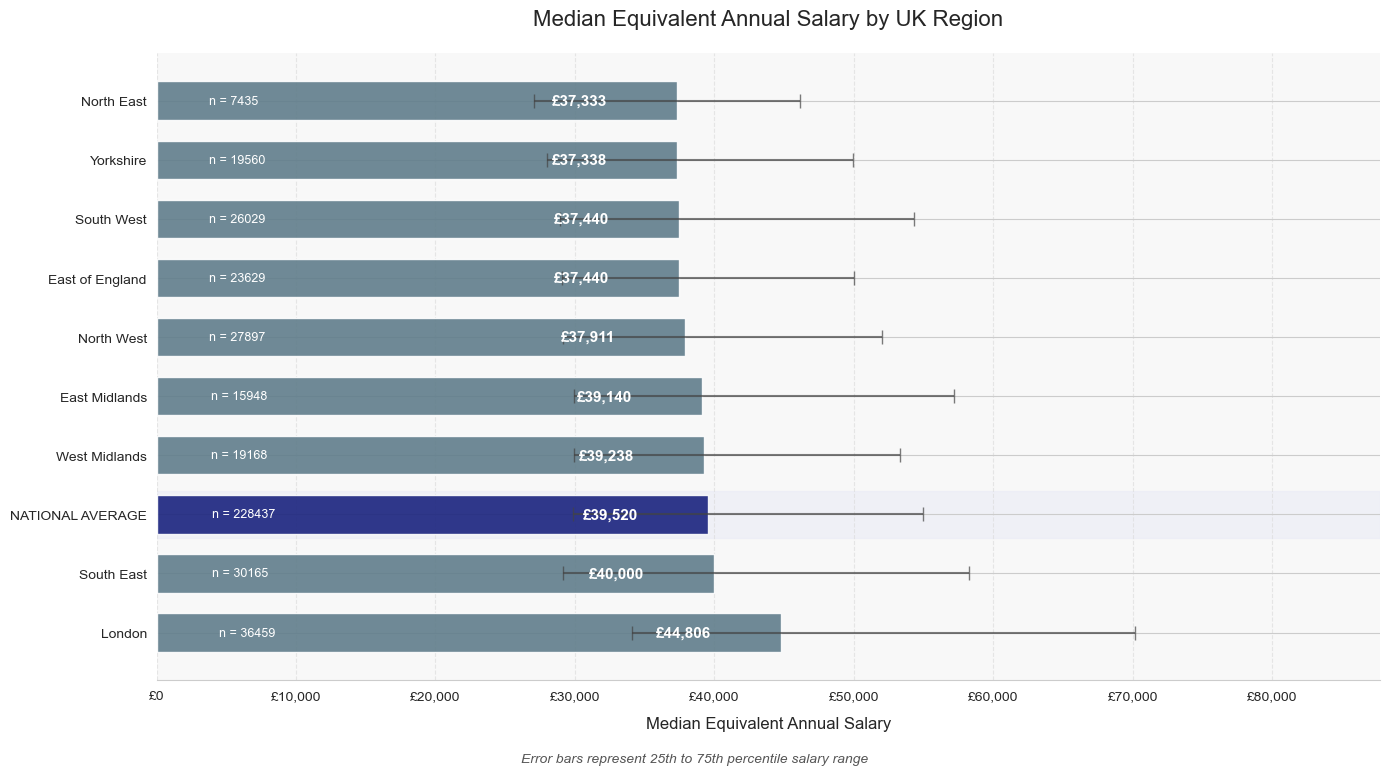

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Calculate median salary by region with national average
def create_region_salary_stats(df):
    # Filter out null values for salary
    clean_df = df[df['equivalent_annual_salary'].notna()]
    
    # Calculate national statistics
    national_median = clean_df['equivalent_annual_salary'].median()
    national_mean = clean_df['equivalent_annual_salary'].mean()
    national_q1 = clean_df['equivalent_annual_salary'].quantile(0.25)
    national_q3 = clean_df['equivalent_annual_salary'].quantile(0.75)
    national_count = len(clean_df)
    
    # Filter for rows with valid regions
    uk_df = clean_df[clean_df['region'].notna()]
    
    # Group by region and calculate statistics
    region_salary = uk_df.groupby('region')['equivalent_annual_salary'].median().reset_index()
    region_salary.columns = ['region', 'median_salary']
    
    region_mean = uk_df.groupby('region')['equivalent_annual_salary'].mean().reset_index()
    region_mean.columns = ['region', 'mean_salary']
    
    region_q1 = uk_df.groupby('region')['equivalent_annual_salary'].quantile(0.25).reset_index()
    region_q1.columns = ['region', 'q1_salary']
    
    region_q3 = uk_df.groupby('region')['equivalent_annual_salary'].quantile(0.75).reset_index()
    region_q3.columns = ['region', 'q3_salary']
    
    # Calculate sample size for each region
    region_counts = uk_df.groupby('region').size().reset_index(name='sample_size')
    
    # Merge all statistics
    region_stats = pd.merge(region_salary, region_counts, on='region')
    region_stats = pd.merge(region_stats, region_mean, on='region')
    region_stats = pd.merge(region_stats, region_q1, on='region')
    region_stats = pd.merge(region_stats, region_q3, on='region')
    
    # Remove "Midlands", "United Kingdom", "Scotland", "Wales", "Northern Ireland" as requested
    regions_to_exclude = ['Midlands', 'United Kingdom', 'Scotland', 'Wales', 'Northern Ireland']
    region_stats = region_stats[~region_stats['region'].isin(regions_to_exclude)]
    
    # Create national average row
    national_row = pd.DataFrame({
        'region': ['NATIONAL AVERAGE'],
        'median_salary': [national_median],
        'sample_size': [national_count],
        'mean_salary': [national_mean],
        'q1_salary': [national_q1],
        'q3_salary': [national_q3]
    })
    
    # Combine and sort by median salary (descending)
    region_stats = pd.concat([region_stats, national_row], ignore_index=True)
    region_stats = region_stats.sort_values('median_salary', ascending=False)
    
    print("Salary statistics by region (including national average):")
    print(region_stats)
    
    return region_stats

# Create a beautiful bar chart with a consistent steel grey color
def plot_salary_bar_chart(region_stats):
    # Set aesthetic style
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'axes.facecolor': '#f8f8f8',
        'figure.facecolor': 'white'
    })
    
    # Calculate IQR for error bars
    region_stats['lower'] = region_stats['median_salary'] - region_stats['q1_salary']
    region_stats['upper'] = region_stats['q3_salary'] - region_stats['median_salary']
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors - steel grey for regular bars, a highlight color for national average
    bar_colors = ['#607D8B' if region != 'NATIONAL AVERAGE' else '#1A237E' 
                 for region in region_stats['region']]
    
    # Create horizontal bar chart
    bars = ax.barh(region_stats['region'], region_stats['median_salary'], 
                  color=bar_colors, alpha=0.9, height=0.65,
                  xerr=np.array([region_stats['lower'], region_stats['upper']]),
                  error_kw={'capsize': 5, 'ecolor': '#444444', 'alpha': 0.7})
    
    # Find the maximum salary for x-axis limit adjustment
    max_salary = region_stats['median_salary'].max()
    max_upper = region_stats['median_salary'] + region_stats['upper']
    absolute_max = max(max_salary, max_upper.max())
    
    # Add salary labels inside or outside bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        salary_formatted = f"£{int(width):,}"
        sample_size = region_stats.iloc[i]['sample_size']
        region_name = region_stats.iloc[i]['region']
        
        # Always place salary values inside bars with white text
        ax.text(width - 5000, i, salary_formatted, 
               va='center', ha='right', color='white', 
               fontweight='bold', fontsize=11)
        
        # Add sample size in white text at the beginning of each bar
        ax.text(width * 0.1, i, f"n = {sample_size}", va='center', ha='left', 
               color='white', fontsize=9, fontweight='normal')
    
    # Format x-axis as GBP
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'£{int(x):,}'))
    
    # Labels and title
    ax.set_xlabel('Median Equivalent Annual Salary', fontsize=12, labelpad=10)
    ax.set_ylabel('')  # No y-label needed as region names are shown
    ax.set_title('Median Equivalent Annual Salary by UK Region', fontsize=16, pad=20)
    
    # Add subtitle explaining error bars
    plt.figtext(0.5, 0.01, "Error bars represent 25th to 75th percentile salary range", 
               ha='center', fontsize=10, style='italic', color='#555555')
    
    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.7, color='#dddddd')
    ax.set_axisbelow(True)  # Put grid below bars
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set x-axis limits - extend further to ensure no labels are cut off
    ax.set_xlim(0, absolute_max * 1.25)  # Increased from 1.15 to 1.25 for more space
    
    # Highlight the national average bar with a subtle background
    for i, region in enumerate(region_stats['region']):
        if region == 'NATIONAL AVERAGE':
            ax.axhspan(i-0.4, i+0.4, color='#E8EAF6', alpha=0.5, zorder=0)
    
    # Tight layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save and show
    plt.savefig('uk_salary_barchart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, ax

# Execute the functions
region_stats = create_region_salary_stats(combined_df)
fig, ax = plot_salary_bar_chart(region_stats)

Top 5 and Bottom 5 Cities by Median Salary:
                   city  median_salary   mean_salary  q1_salary  q3_salary  sample_size
0              Wadhurst        93860.0  84378.467577   43680.00  111800.00          293
1               Cheadle        90740.0  72615.539759   39215.00   94120.00          415
2              Edmonton        83200.0  85975.068670   73840.00   93860.00          466
3             Greenwich        83200.0  84852.088608   42122.00  100620.00          158
4             Orpington        80860.0  72264.794872   42939.00   98280.00          351
5      NATIONAL AVERAGE        39520.0  51106.326475   29840.00   55000.00       228437
6   Newcastle upon Tyne        29970.0  35635.903992   24960.00   40865.00         1052
7            Tewkesbury        28541.5  34252.504808   24960.00   32887.75          208
8              Hinckley        28311.0  38865.000000   24295.00   46148.00          250
9             Aldershot        28268.5  37204.180000   24894.75   45762.00  

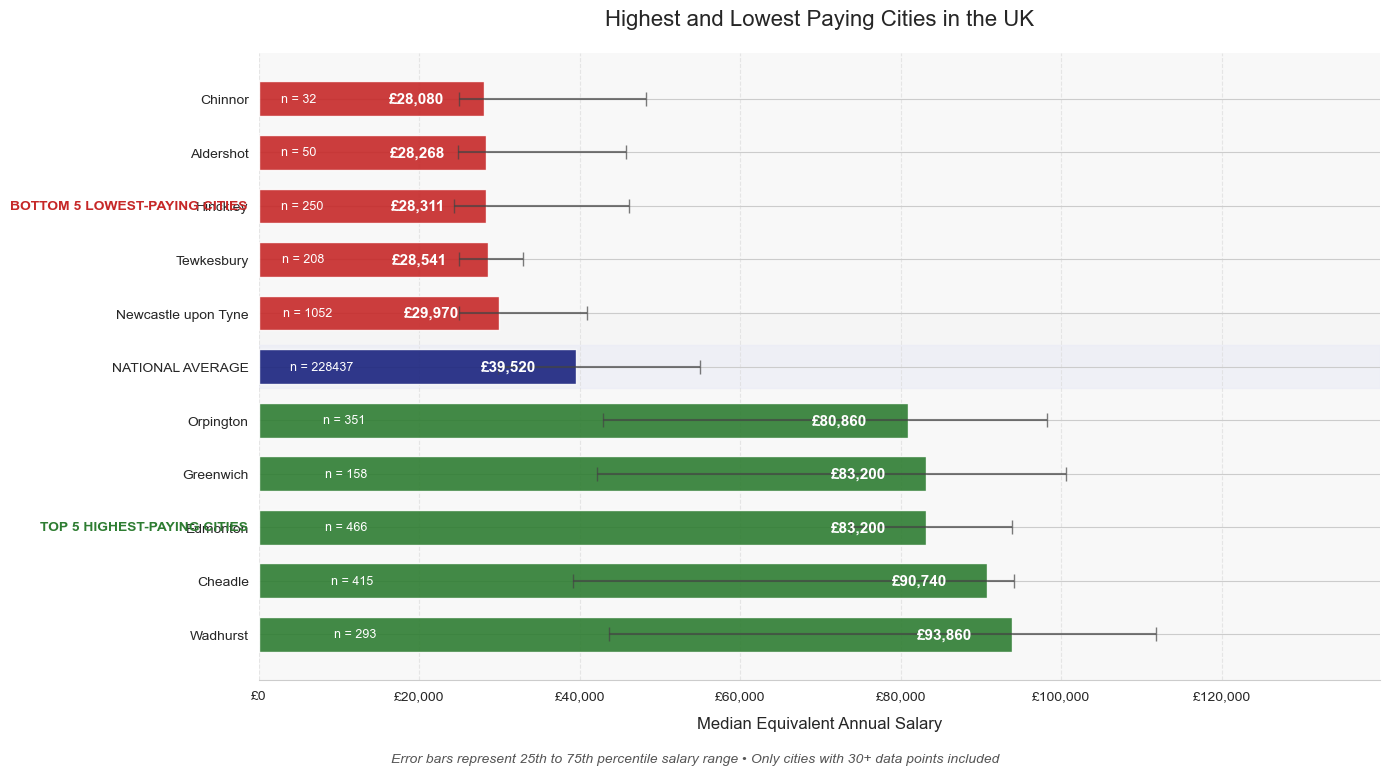

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Calculate median salary by city and identify top/bottom 5
def create_city_salary_comparison(df):
    # Filter out null values for salary and city
    clean_df = df[(df['equivalent_annual_salary'].notna()) & (df['city'].notna())]
    
    # Calculate national statistics
    national_median = df['equivalent_annual_salary'].median()
    national_mean = df['equivalent_annual_salary'].mean()
    national_q1 = df['equivalent_annual_salary'].quantile(0.25)
    national_q3 = df['equivalent_annual_salary'].quantile(0.75)
    national_count = len(df[df['equivalent_annual_salary'].notna()])
    
    # Group by city and calculate statistics
    city_stats = clean_df.groupby('city').agg(
        median_salary=('equivalent_annual_salary', 'median'),
        mean_salary=('equivalent_annual_salary', 'mean'),
        q1_salary=('equivalent_annual_salary', lambda x: x.quantile(0.25)),
        q3_salary=('equivalent_annual_salary', lambda x: x.quantile(0.75)),
        sample_size=('equivalent_annual_salary', 'count')
    ).reset_index()
    
    # Filter out cities with small sample sizes (less than 30 for statistical significance)
    city_stats = city_stats[city_stats['sample_size'] >= 30]
    
    # Sort cities by median salary
    city_stats_sorted = city_stats.sort_values('median_salary', ascending=False)
    
    # Get top 5 and bottom 5 cities
    top_5_cities = city_stats_sorted.head(5)
    bottom_5_cities = city_stats_sorted.tail(5)
    
    # Create national average row
    national_row = pd.DataFrame({
        'city': ['NATIONAL AVERAGE'],
        'median_salary': [national_median],
        'mean_salary': [national_mean],
        'q1_salary': [national_q1],
        'q3_salary': [national_q3],
        'sample_size': [national_count]
    })
    
    # Combine top 5, national average, and bottom 5
    comparison_data = pd.concat([top_5_cities, national_row, bottom_5_cities], ignore_index=True)
    
    print("Top 5 and Bottom 5 Cities by Median Salary:")
    print(comparison_data)
    
    return comparison_data

# Create a bar chart showing top 5 and bottom 5 cities versus national average
def plot_city_salary_comparison(city_data):
    # Set aesthetic style
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'axes.facecolor': '#f8f8f8',
        'figure.facecolor': 'white'
    })
    
    # Calculate IQR for error bars
    city_data['lower'] = city_data['median_salary'] - city_data['q1_salary']
    city_data['upper'] = city_data['q3_salary'] - city_data['median_salary']
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors
    colors = []
    for city in city_data['city']:
        if city == 'NATIONAL AVERAGE':
            colors.append('#1A237E')  # Dark blue for national average
        elif city_data[city_data['city'] == city].index[0] < 5:
            colors.append('#2E7D32')  # Green for top 5
        else:
            colors.append('#C62828')  # Red for bottom 5
    
    # Create horizontal bar chart
    bars = ax.barh(city_data['city'], city_data['median_salary'], 
                  color=colors, alpha=0.9, height=0.65,
                  xerr=np.array([city_data['lower'], city_data['upper']]),
                  error_kw={'capsize': 5, 'ecolor': '#444444', 'alpha': 0.7})
    
    # Find the maximum salary for x-axis limit adjustment
    max_salary = city_data['median_salary'].max()
    max_upper = city_data['median_salary'] + city_data['upper']
    absolute_max = max(max_salary, max_upper.max())
    
    # Add salary labels and sample sizes
    for i, bar in enumerate(bars):
        width = bar.get_width()
        salary_formatted = f"£{int(width):,}"
        sample_size = city_data.iloc[i]['sample_size']
        city_name = city_data.iloc[i]['city']
        
        # Always place salary values inside bars with white text
        ax.text(width - 5000, i, salary_formatted, 
               va='center', ha='right', color='white', 
               fontweight='bold', fontsize=11)
        
        # Add sample size in white text at the beginning of each bar
        ax.text(width * 0.1, i, f"n = {sample_size}", va='center', ha='left', 
               color='white', fontsize=9, fontweight='normal')
    
    # Format x-axis as GBP
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'£{int(x):,}'))
    
    # Labels and title
    ax.set_xlabel('Median Equivalent Annual Salary', fontsize=12, labelpad=10)
    ax.set_ylabel('')  # No y-label needed as city names are shown
    ax.set_title('Highest and Lowest Paying Cities in the UK', fontsize=16, pad=20)
    
    # Add subtitle explaining the visualization
    plt.figtext(0.5, 0.01, "Error bars represent 25th to 75th percentile salary range • Only cities with 30+ data points included", 
               ha='center', fontsize=10, style='italic', color='#555555')
    
    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.7, color='#dddddd')
    ax.set_axisbelow(True)  # Put grid below bars
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set x-axis limits - extend further to ensure no labels are cut off
    ax.set_xlim(0, absolute_max * 1.25)
    
    # Add a light bar to separate top 5 from bottom 5
    middle_index = 5.5  # Between national average and bottom 5
    ax.axhspan(middle_index-0.5, middle_index+0.5, color='#F5F5F5', alpha=1.0, zorder=0)
    
    # Highlight the national average
    for i, city in enumerate(city_data['city']):
        if city == 'NATIONAL AVERAGE':
            ax.axhspan(i-0.4, i+0.4, color='#E8EAF6', alpha=0.5, zorder=0)
    
    # Add annotations for top and bottom 5
    ax.text(-0.01, 2, "TOP 5 HIGHEST-PAYING CITIES", ha='right', va='center', 
           color='#2E7D32', fontweight='bold', fontsize=10,
           transform=ax.get_yaxis_transform())
    
    ax.text(-0.01, 8, "BOTTOM 5 LOWEST-PAYING CITIES", ha='right', va='center', 
           color='#C62828', fontweight='bold', fontsize=10,
           transform=ax.get_yaxis_transform())
    
    # Tight layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save and show
    plt.savefig('uk_cities_salary_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, ax

# Execute the functions
city_comparison = create_city_salary_comparison(combined_df)
fig, ax = plot_city_salary_comparison(city_comparison)